# Introduction

This Jupyter Notebook focuses on analyzing financial data using various accounting variables. The code imports necessary libraries such as pandas, os, re, numpy, wrds, and dotenv. It also loads the environment variables using the `load_dotenv()` function.

The notebook is divided into several sections, each serving a specific purpose. Let's go through each section and understand its functionality.

## [Import the libraries](#Import-the-libraries)

In this section, the required libraries are imported. These libraries include pandas, os, re, numpy, wrds, and dotenv. The `load_dotenv()` function is used to load the environment variables.

## Set the parameters

This section sets the parameters for the analysis. The `nlp_model` parameter specifies the type of NLP model to be used, such as 'doc2vec' or 'tfidf' or 'wordcount' or 'lda' or 'mpnet' or 'ada'. The `doc2vec_vector_size` parameter specifies the size of the vector for the doc2vec model.

Other parameters such as `previously_downloaded_recoms`, `previously_downloaded_estimates`, `previously_downloaded_segments`, `previously_downloaded_Loughran_McDonald`, and `have_sp500_index` are boolean variables that indicate whether the corresponding data has been previously downloaded.

The `ind_col` parameter specifies the column to be used as the industry identifier, such as 'naicsh6' or 'sich'. The `ind_type` parameter specifies the type of industry identifier, either 'naicsh' or 'sich'.

## CRSP/Compustat accounting vars

In this section, the CRSP/Compustat accounting variables are loaded from a pickle file. The data is filtered based on certain criteria such as data format, population source, consolidation, and industry format. Additional columns such as 'month', 'year', 'cusip_8', 'sich4', 'sich3', 'sich2', 'naicsh6', 'naicsh5', 'naicsh4', 'naicsh3', and 'naicsh2' are added to the dataframe.

Various accounting variables are calculated based on the existing columns, such as number of employees, EPA, slack measures, R&D share of total expense, advertising share of total expense, recognized intangible assets as part of total assets, depreciation as part of total assets, total merger, and leverage. Additionally, the number of unique firms for each industry-year combination is calculated.

## Winsorizing the accounting variables

In this section, a function called `winsorize` is defined to winsorize the accounting variables. The function takes an input series and a percentile value as parameters and returns the winsorized output series. The accounting variables are winsorized using the `winsorize` function.

## Adding the number of unique analysts for each industry-year

In this section, the number of unique analysts for each industry-year combination is calculated using the estimates data. The estimates data is filtered based on certain criteria and merged with the compustat data. The resulting dataframe is then merged with the compustat data to add the number of unique analysts as a new column.

## Average portfolio size of analysts following each firm

In this section, the average portfolio size of analysts following each firm is calculated using the estimates data. The estimates data is filtered based on certain criteria and grouped by firm and year. The average portfolio size is calculated as the mean of the analyst coverage for each firm-year combination. The resulting dataframe is then merged with the compustat data to add the average portfolio size as a new column.

## Adding variables using compustat segments data

In this section, the compustat segments data is loaded from a CSV file. The data is filtered based on certain criteria and processed to calculate the number of segments for each firm-year combination. The resulting dataframe is then merged with the compustat data to add the number of segments as a new column.

## Strategy Uniqueness using Litov et al. (2012) method

In this section, the strategy uniqueness measure is calculated using the Litov et al. (2012) method. The compustat segments data is processed to calculate the primary SIC code for each firm-year combination. The total sales for each industry-year combination are calculated, and the normalized sales for each firm-year combination are calculated. The firm-year matrix and industry-year matrix are created, and the differences between the firm-year matrix and industry-year matrix are calculated. The sum of squared differences is calculated as the strategy uniqueness measure. The resulting dataframe is then merged with the compustat data to add the strategy uniqueness measure as a new column.

## Industry concentration vars

In this section, the industry concentration variables are calculated using the compustat data. The total sales for each industry-year combination are calculated, and the market share and Herfindahl-Hirschman Index (HHI) are calculated. The resulting dataframe is then merged with the compustat data to add the market share and HHI as new columns.

## Adding S&P500 membership data

In this section, the S&P500 membership data is loaded from a CSV file. The compustat data is merged with the S&P500 membership data to add the S&P500 membership indicator as a new column.

## Add the 10K variables

In this section, the 10K variables are loaded from a pickle file. The compustat data is merged with the 10K variables to add the 10K variables as new columns.

## Add Loughran and McDonal 10-K variable

In this section, the Loughran and McDonal 10-K variables are loaded from a CSV file. The compustat data is merged with the Loughran and McDonal 10-K variables to add the variables as new columns.

## Adding mean of dependent variables for each industry and year

In this section, the mean of the dependent variables for each industry and year is calculated using the compustat data. The mean of the 'meanrec' and 'numrec' variables is calculated for each industry-year combination. The resulting dataframe is then merged with the compustat data to add the mean of the dependent variables as new columns.

## Adding exemplar performance var

In this section, the exemplar performance variables are added to the compustat data. The exemplar finance variables are merged with the compustat data based on the 'exemplar' industry identifier and year. The resulting dataframe is then merged with the compustat data to add the exemplar performance variables as new columns.

## Saving the database

In this section, the final selected variables from the compustat data are saved as a pickle file.

## Visualizing the descriptives of the variables

In this section, the descriptive statistics of the selected variables are visualized using histograms. Each variable is plotted as a histogram to show its distribution.

Overall, this Jupyter Notebook performs various data processing and analysis tasks on the compustat data to calculate and add several accounting and financial variables. These variables can be used for further analysis and modeling.

# Import the libraries

In [136]:
import pandas as pd
import os
import re
import numpy as np
import wrds
from dotenv import load_dotenv

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pgeocode

load_dotenv()

FileNotFoundError: [Errno 2] No such file or directory

In [ ]:

# Set the font to Times New Roman
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'

# Set the parameters

In [ ]:

nlp_model = 'mpnet' # 'doc2vec' or 'tfidf' or 'wordcount' or 'lda' or 'mpnet' or 'ada'
doc2vec_vector_size = 768 # 768 or 1536

previously_downloaded_recoms = True
previously_downloaded_estimates = True
previously_downloaded_Loughran_McDonald = True
have_sp500_index = True

ind_col = 'naicsh6' 
ind_type = 'naicsh' # 'naicsh' or 'sich'

# CRSP/Compustat accounting vars

Assumption is that the file has been downloaded before

In [ ]:
compustat = pd.read_pickle('../data/csrp_compustat1989_2023.pkl')

compustat=compustat[compustat.datafmt=='STD']
compustat=compustat[compustat.popsrc=='D']
compustat=compustat[compustat.consol=='C']
compustat=compustat[compustat.indfmt== 'INDL']


compustat['month']=compustat['datadate'].dt.month
compustat['year']=compustat['datadate'].dt.year
compustat['cusip_8']=compustat.cusip.apply(lambda x: x[:8])
compustat.drop_duplicates(['GVKEY','datadate'], inplace=True)
compustat.drop_duplicates(['cusip_8','year'], inplace=True)
compustat.drop_duplicates(['cik','year'], inplace=True)
compustat['GVKEY'] = compustat['GVKEY'].astype(int)

compustat.dropna(subset=['cik'], inplace=True)
compustat['cik']  = compustat['cik'].astype(str)
compustat = compustat[compustat['cik'].str.len() > 0]
compustat['cik']  = compustat['cik'].astype(int)


if ind_type == 'sich':
  compustat['sich'] = compustat['sich'].replace('', np.nan)
  compustat = compustat.loc[compustat['sich'].notna()]
  compustat.loc[:, 'sich4'] = compustat['sich'].astype(int).astype(str).str.pad(width=4, side='right', fillchar='0').astype(int)
  compustat.loc[:, 'sich3'] = compustat['sich4'] // 10
  compustat.loc[:, 'sich2'] = compustat['sich4'] // 100

elif ind_type == 'naicsh':
  compustat['naicsh'] = compustat['naicsh'].replace('', np.nan)
  compustat = compustat.loc[compustat['naicsh'].notna()]
  compustat.loc[:, 'naicsh6'] = compustat['naicsh'].astype(int).astype(str).str.pad(width=6, side='right', fillchar='0').astype(int)
  compustat.loc[:, 'naicsh5'] = compustat['naicsh6'] // 10
  compustat.loc[:, 'naicsh4'] = compustat['naicsh6'] // 100
  compustat.loc[:, 'naicsh3'] = compustat['naicsh6'] // 1000
  compustat.loc[:, 'naicsh2'] = compustat['naicsh6'] // 10000

In [ ]:

#Number of employees
compustat['n_emp'] = compustat['emp']

# EPA
compustat['EPS'] = np.where(compustat['csho'] != 0, compustat['ni'] / compustat['csho'], np.nan)

# slack measures
compustat['slack_avail'] = compustat['act'] / compustat['lct'].where(compustat['lct'] != 0, np.nan)
compustat['slack_avail'] = compustat['slack_avail'].fillna(0)

# r&d share of total expense
compustat['rd_f'] = compustat['xrd'] / compustat['xopr'].where(compustat['xopr'] != 0, np.nan)
compustat['rd_f'] = compustat['rd_f'].fillna(0)

# advertising share of total expense
compustat['adv_f'] = compustat['xad'] / compustat['xopr'].where(compustat['xopr'] != 0, np.nan)
compustat['adv_f'] = compustat['adv_f'].fillna(0)

# recognized intangible assets as part of total assets
compustat['intang_f'] = compustat['intan'] / compustat['at'].where(compustat['at'] != 0, np.nan)
compustat['intang_f'] = compustat['intang_f'].fillna(0)

# depreciation as part of total assets
compustat['dpt_f'] = compustat['dp'] / compustat['at'].where(compustat['at'] != 0, np.nan)
compustat['dpt_f'] = compustat['dpt_f'].fillna(0)

#Total merger
compustat['mergers'] = compustat['aqp'].fillna(0)

# Leverage
compustat['leverage'] = (compustat['dltt'] + compustat['dlc']) / compustat['seq']
compustat.loc[compustat['seq'] == 0, 'leverage'] = np.nan

compustat[f'no_firms_{ind_col}']=compustat.groupby([ind_col,'year'])['GVKEY'].transform('nunique')

### Add Proximity to a Financial Hub Variable

In [ ]:
# Amirican cities recoginzed in the top 20 list of Global Financial Centres Index (GFCI) 2023
# New York City, San Francisco, Los Angeles, Chicago,  Washington D.C., Boston

In [ ]:
compustat['proximity_financial_centre'] = np.where(compustat['city'].isin(['New York', 'San Francisco', 'LOS ANGELES', 'Chicago', 'Washington', 'Boston']), 1, 0)

In [ ]:
compustat['proximity_financial_centre'].value_counts()

0    176840
1     17011
Name: proximity_financial_centre, dtype: int64

## Winsorizing the accounting variables

In [ ]:

def winsorize(input_series, p):
    q_bottom = input_series.quantile(p/100)
    q_top = input_series.quantile(1-p/100)
    output_series = input_series.clip(lower=q_bottom, upper=q_top)
    return output_series

# Winsorizing accounting variables
winsorize_cols = ['EPS','sale', 'slack_avail', 'rd_f', 'adv_f', 'intang_f', 'dpt_f', 'leverage', 'mergers']

    
for col in winsorize_cols:
    compustat[col+'_wins_1'] = winsorize(compustat[col], 1)

In [ ]:
compustat['rd_f_wins_1'].fillna(0, inplace=True)
compustat['adv_f_wins_1'].fillna(0, inplace=True)
compustat['dpt_f_wins_1'].fillna(0, inplace=True)
compustat['intang_f_wins_1'].fillna(0, inplace=True)
compustat['mergers_wins_1'].fillna(0, inplace=True)

# Adding the number of unique analysts for each industry-year

In [ ]:

if previously_downloaded_estimates == False:

    wrds_username = os.getenv('WRDS_USERNAME')
    wrds_password = os.getenv('WRDS_PASSWORD')
    db_wrds = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)

    # replace with wrdssec.forms
    query = f"""
        SELECT *
        FROM tr_ibes.det_epsus
        WHERE fpi='1' AND measure='EPS' AND usfirm='1'
    """

    estimates = db_wrds.raw_sql(query)
    estimates.to_csv('../data/estimates_detail.csv')

else:
    estimates = pd.read_csv('../data/estimates_detail.csv')


compustat_select = compustat[['cusip_8', 'year', f'{ind_col}']]
compustat_select.columns = ['cusip', 'year', f'{ind_col}']

estimates['fpedats'] = estimates['FPEDATS'].astype(str).str.replace('-', '').astype(int)
estimates['year'] = estimates['fpedats'] // 10000
estimates = estimates[['CUSIP', 'ANALYS', 'year']]
estimates.columns = ['cusip', 'ANALYS', 'year']
estimates = pd.merge(estimates, compustat_select, on=['cusip', 'year'],
                     how='left')


n_an_naics = estimates.groupby([ind_col, 'year'])['ANALYS'].nunique().reset_index()
n_col = 'n_analysts_' + ind_col
n_an_naics.columns = [ind_col, 'year', n_col]

compustat = compustat.merge(n_an_naics,
                            on=[ind_col, 'year'], how='left')


/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_36523/658291440.py:18: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  estimates = pd.read_csv('../data/estimates_detail.csv')


In [ ]:
estimates = estimates[estimates['ANALYS'] != 0]

# number of firms per analyst per year
n_firms_analyst = estimates.groupby(['ANALYS', 'year'])['cusip'].nunique()

In [ ]:
n_firms_analyst.describe()

count    130995.000000
mean          8.713058
std           8.797648
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         296.000000
Name: cusip, dtype: float64

In [ ]:
# Resetting index for the DataFrame to be compatible with seaborn
n_firms_analyst = n_firms_analyst.reset_index(name='nunique')

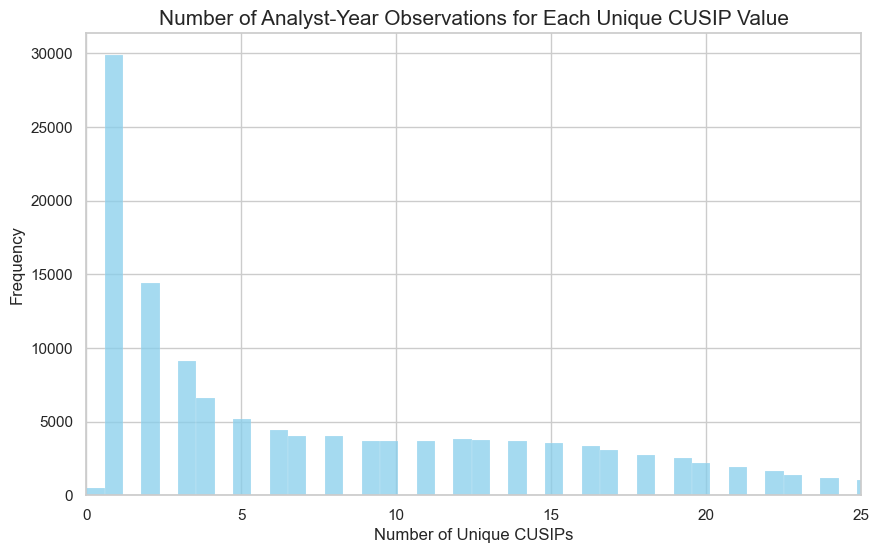

In [ ]:

# Setting up seaborn aesthetics
sns.set(style="whitegrid")

# Adjusting the figure size
plt.figure(figsize=(10, 6))

# Creating a histogram using seaborn
sns.histplot(n_firms_analyst['nunique'], bins=500, color='skyblue')

# Adding title and labels
plt.title('Number of Analyst-Year Observations for Each Unique CUSIP Value', fontsize=15)
plt.xlabel('Number of Unique CUSIPs', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.xlim([0, 25])

# Display the plot
plt.show()

# Average portfolio size of analysts following each firm

In [ ]:

estimates = estimates[estimates['ANALYS'] != 0]
estimates['analyst_coverage'] = estimates.groupby(['ANALYS', 'year'])['cusip'].transform('nunique')
firm_average_coverage = estimates.drop_duplicates(
    ['cusip', 'year', 'ANALYS']).groupby(['cusip', 'year'])['analyst_coverage'].mean().reset_index(
    name='firm_average_analyst_coverage')
firm_average_coverage.firm_average_analyst_coverage.mean()

# compustat on cusip_8 and year and firm_average_coverage on cusip and year
compustat = compustat.merge(firm_average_coverage, left_on=['cusip_8', 'year'],
                            right_on=['cusip', 'year'], how='left')

# Adding variables using compustat segments data

In [ ]:
# We have downloaded the Compustat Segments from WRDS web interface
# WRDS does not keep the aggregated segments data as a standalone dataset, so we have to download it from the web interface
# We downloaded all data from 1995
# We kept all the default settings for the download (downloaded all segments and all source years)

segments = pd.read_csv('../data/compustat_segments.csv')

/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_36523/1740466394.py:6: DtypeWarning: Columns (7,16,19,48,60,89) have mixed types. Specify dtype option on import or set low_memory=False.
  segments = pd.read_csv('../data/compustat_segments.csv')


## Number of segments for each firm

In [ ]:
segments.drop_duplicates(['gvkey', 'datadate','srcdate'])
segments.drop_duplicates(['gvkey', 'datadate', 'sid'])
segments = segments[['gvkey', 'datadate', 'sid', 'sales']]
segments_n = segments.groupby(['gvkey', 'datadate'])['sid'].nunique().reset_index()
segments_n = segments_n.rename(columns={'gvkey': 'GVKEY'})
segments_n = segments_n.rename(columns={'sid': 'n_segments'})

segments_n['year'] = segments_n['datadate'].str.slice(0,4).astype(int)
segments_n = segments_n[['GVKEY', 'year', 'n_segments']]

compustat = compustat.merge(segments_n, on=['GVKEY', 'year'], how='left',
                                  suffixes=('_df1', ''))
compustat['n_segments'].fillna(1,inplace=True)

## Strategy Uniqueness using Litov et al. (2012) method

In [ ]:
if ind_type == 'naicsh':
    seg_ind = 'NAICSS1'
elif ind_type == 'sich':
    seg_ind = 'SICS1'

segments = pd.read_csv('../data/compustat_segments.csv')
segments['year'] = segments['datadate'].str.slice(0,4).astype(int)
segments = segments[(segments['stype'] == 'BUSSEG') | (segments['stype'] == 'OPSEG')]
segments = segments[['gvkey', 'year', 'sales', seg_ind ]]
segments = segments[segments['sales'] > 0]
segments = segments[segments[seg_ind].notnull()]
segments = segments[segments[seg_ind] != '']
segments = segments[segments[seg_ind] != 0]
segments[seg_ind] = segments[seg_ind].astype(int)
segments['year'] = segments['year'].astype(int)
segments['gvkey'] = segments['gvkey'].astype(int)
segments = segments.rename(columns={'gvkey': 'GVKEY'})
segments = segments.rename(columns={seg_ind: 'segment_sic'})
segments = segments.rename(columns={'sales': 'segment_sale'})
segments = segments.groupby(['GVKEY', 'year', 'segment_sic'])['segment_sale'].sum().reset_index(name='segment_sale')
segments['segment_sic'] = segments['segment_sic'].astype(int)

/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_36523/3169077402.py:6: DtypeWarning: Columns (7,16,19,48,60,89) have mixed types. Specify dtype option on import or set low_memory=False.
  segments = pd.read_csv('../data/compustat_segments.csv')


In [ ]:

# Step 1
idx = segments.groupby(['GVKEY', 'year'])['segment_sale'].idxmax()
segments['primary_sic'] = segments.loc[idx, 'segment_sic']
segments['primary_sic'] = segments.groupby(['GVKEY', 'year'])['primary_sic'].transform('max')

# Step 2
total_sales = segments.groupby(['GVKEY', 'year'])['segment_sale'].transform('sum')
segments['norm_sale'] = segments['segment_sale'] / total_sales

# Step 3
firm_year_matrix = segments.pivot_table(index=['GVKEY', 'year', 'primary_sic'],
                                        columns='segment_sic',
                                        values='norm_sale').fillna(0)

# Step 4
actual_sales_matrix = segments.pivot_table(index=['GVKEY', 'year', 'primary_sic'],
                                           columns='segment_sic',
                                           values='segment_sale').fillna(0)

industry_year_sales = actual_sales_matrix.groupby(['primary_sic', 'year']).sum()

# Step 5
total_industry_sales = industry_year_sales.sum(axis=1)
norm_industry_year_sales = industry_year_sales.div(total_industry_sales, axis=0)

# Step 6
diff_matrix = firm_year_matrix.subtract(norm_industry_year_sales, axis=1)

# step 7: sum of squared differences
squared_diff_matrix = diff_matrix ** 2
sum_squared_diff = squared_diff_matrix.sum(axis=1)

uniqueness = sum_squared_diff.reset_index(name='strategy_unique')

In [ ]:
compustat = compustat.merge(uniqueness, on=['GVKEY', 'year'], how='left')

# Industry concentration vars


In [ ]:
total_sales = compustat.groupby(['year', ind_col])['sale'].sum().reset_index(name=f'total_sales_{ind_col}')
compustat = compustat.merge(total_sales, on=['year', ind_col])
compustat[f'market_share_{ind_col}'] = compustat['sale'] / compustat[f'total_sales_{ind_col}']

In [ ]:
compustat[f'squared_market_share_{ind_col}'] = compustat[f'market_share_{ind_col}'] ** 2
hhi = compustat.groupby(['year', ind_col])[f'squared_market_share_{ind_col}'].sum().reset_index(name=f'hhi_{ind_col}')
compustat = compustat.merge(hhi, on=['year', ind_col])

# Adding S&P500 membership data

In [ ]:
# the spx500 index is manually selected, since we did not have access to the index file on WRDS
# if you don't have the spx500 index, you can set have_sp500_index to False
# this will essentially remove this variable from the regression models by setting its value to 0

if have_sp500_index:
    sp500 = pd.read_csv('../data/spx500.csv')
    compustat = compustat.merge(sp500, on=['GVKEY', 'year'], how='left',
                                    suffixes=('_df1', ''))
    compustat['is_spx500'].fillna(0, inplace=True)
else:
    compustat['is_spx500'] = 0

In [ ]:
compustat['is_spx500'].value_counts()

0.0    180446
1.0     13725
Name: is_spx500, dtype: int64

# Add the 10K variables


In [ ]:
database2 = pd.read_pickle(f'../data/NLP/10k_vars_{nlp_model}_{str(doc2vec_vector_size)}_{ind_col}.pkl')
database2.drop_duplicates(['GVKEY', 'year'])

,GVKEY,year,meanrec,numrec,meanrec_mean,numrec_mean,meanrec_descend,meanrec_mean_descend,numrec_mean_0,composite_var,...,exemplar_naicsh6_gvkey,exemplar_sim_naicsh6,sim_mean_naicsh6,exemplar_naicsh6_typicality,category_coherence_naicsh6,ind_vecs_change_naicsh6,ind_sim_all_naicsh6_distinct,sim_5nearest,sim_10nearest,sim_20nearest
0,1004,1990,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1004,1991,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1004,1992,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1004,1993,NaN,NaN,4.335,2.0,NaN,1.665,2.0,-3.895190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1004,1994,3.5,4.0,3.517,3.9,2.5,2.483,3.9,-2.194525,...,NaN,NaN,1.000000,NaN,1.000000,NaN,-0.730866,0.790181,0.783866,0.760588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193846,348892,2021,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,1.000000,0.008357,-0.793153,NaN,NaN,NaN
193847,349530,2022,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,1.000000,NaN,1.000000,0.222460,-0.744395,0.785933,0.757818,0.728004
193848,349972,2021,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,35270.0,0.923401,0.923238,0.950694,0.925118,0.000169,-0.559193,0.926823,0.923629,0.919795
193849,350681,2021,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,0.885594,0.001655,-0.814091,NaN,NaN,NaN


In [ ]:
compustat = compustat.merge(database2, on=['GVKEY', 'year'], how='right')

# Add Loughran and McDonal 10-K variable
this is the link provided by the authors on their website: https://sraf.nd.edu/


## Firm complexity measure

In [ ]:
if previously_downloaded_Loughran_McDonald == False:
    url = 'https://drive.google.com/uc?export=download&id=1FnpCIdiRtomPXJm4s-DD0iFY4YMbEfQz'
    firm_complexity = pd.read_csv(url)
    firm_complexity.to_csv('../data/firm_complexity.csv', index=False)
else:
    firm_complexity = pd.read_csv('../data/firm_complexity.csv')

firm_complexity.columns # Index(['cik', 'filingdate', 'complexity', 'log_netfilesize'], dtype='object')
#filingdate to year; format: 20211214
firm_complexity['year'] = firm_complexity['filingdate'].astype(str).str[:4].astype(int)
firm_complexity = firm_complexity[['cik', 'year', 'complexity']]
firm_complexity.columns = ['cik', 'year', 'firm_complexity']
firm_complexity['cik'] = firm_complexity['cik'].astype(int)

compustat = compustat.merge(firm_complexity, left_on=['cik', 'year'], right_on=['cik', 'year'], how='left')
compustat['firm_complexity'] = compustat['firm_complexity'].fillna(compustat['firm_complexity'].mean())

## Filing Dictionary Summaries

In [ ]:
# add filing dictionary summaries provided by Loughran and McDonald
# this is the link provided by the authors on their website: https://sraf.nd.edu/
if previously_downloaded_Loughran_McDonald == False:
    import gdown
    url = 'https://drive.google.com/u/0/uc?id=1CUzLRwQSZ4aUTfPB9EkRtZ48gPwbCOHA&export=download'
    gdown.download(url, output, quiet=False)
    filing_headers = pd.read_csv(output)
    filing_headers.to_csv('../data/filing_headers.csv', index=False)
else:
    filing_headers = pd.read_csv('../data/filing_headers.csv')

In [ ]:

filing_headers = filing_headers[filing_headers['FORM_TYPE']=='10-K']
filing_headers['year'] = filing_headers['FILING_DATE'].astype(str).str[:4].astype(int)
filing_headers.drop_duplicates(['CIK', 'year'], inplace=True)
filing_headers = filing_headers[['CIK', 'year', 'N_Words', 'N_Unique_Words', 'N_Negative',
                                 'N_Positive','N_Uncertainty', 'N_Litigious', 'N_StrongModal',
                                 'N_WeakModal','N_Constraining', 'N_Negation']]
# normalize by number of words
filing_headers['N_Unique_Words'] = filing_headers['N_Unique_Words'] / filing_headers['N_Words']
filing_headers['N_Negative'] = filing_headers['N_Negative'] / filing_headers['N_Words']
filing_headers['N_Positive'] = filing_headers['N_Positive'] / filing_headers['N_Words']
filing_headers['N_Uncertainty'] = filing_headers['N_Uncertainty'] / filing_headers['N_Words']
filing_headers['N_Litigious'] = filing_headers['N_Litigious'] / filing_headers['N_Words']
filing_headers['N_StrongModal'] = filing_headers['N_StrongModal'] / filing_headers['N_Words']
filing_headers['N_WeakModal'] = filing_headers['N_WeakModal'] / filing_headers['N_Words']
filing_headers['N_Constraining'] = filing_headers['N_Constraining'] / filing_headers['N_Words']
filing_headers['N_Negation'] = filing_headers['N_Negation'] / filing_headers['N_Words']

filing_headers['positive_negative_ratio'] = filing_headers['N_Positive'] / filing_headers['N_Negative']
filing_headers['strong_weak_modal_ratio'] = filing_headers['N_StrongModal'] / filing_headers['N_WeakModal']


In [ ]:

# merge with compustat, replace the missing values of the new variables with 0
compustat = compustat.merge(filing_headers, left_on=['cik', 'year'], right_on=['CIK', 'year'], how='left')

In [ ]:

compustat['N_Words'].fillna(compustat['N_Words'].mean(), inplace=True)
compustat['N_Unique_Words'].fillna(compustat['N_Unique_Words'].mean(), inplace=True)
compustat['N_Negative'].fillna(compustat['N_Negative'].mean(), inplace=True)
compustat['N_Positive'].fillna(compustat['N_Positive'].mean(), inplace=True)
compustat['N_Uncertainty'].fillna(compustat['N_Uncertainty'].mean(), inplace=True)
compustat['N_Litigious'].fillna(compustat['N_Litigious'].mean(), inplace=True)
compustat['N_StrongModal'].fillna(compustat['N_StrongModal'].mean(), inplace=True)
compustat['N_WeakModal'].fillna(compustat['N_WeakModal'].mean(), inplace=True)
compustat['N_Constraining'].fillna(compustat['N_Constraining'].mean(), inplace=True)
compustat['N_Negation'].fillna(compustat['N_Negation'].mean(), inplace=True)
compustat['positive_negative_ratio'].fillna(compustat['positive_negative_ratio'].mean(), inplace=True)
compustat['strong_weak_modal_ratio'].fillna(compustat['strong_weak_modal_ratio'].mean(), inplace=True)
compustat.drop(columns=['CIK'], inplace=True)


# Adding mean of dependent variables for each industry and year


In [ ]:
compustat[f'meanrec_avg_year_{ind_col}'] = compustat.groupby(['year', ind_col])['meanrec_descend'].transform('mean')
compustat[f'numrec_avg_year_{ind_col}'] = compustat.groupby(['year', ind_col])['numrec'].transform('mean')


# Adding exemplar performance var


In [ ]:
# Adding exemplar finance vars
exemplar_fin_vars = compustat[['GVKEY','year','EPS_wins_1' ]]

exem_gvkey_col = 'exemplar_'+ind_col+"_gvkey"
suffix_ex = "_ex_" + ind_col
compustat = compustat.merge(
    exemplar_fin_vars, left_on=[exem_gvkey_col, 'year'], right_on=['GVKEY', 'year'],
    how='left', suffixes=("", suffix_ex))

compustat.drop_duplicates(['GVKEY', 'year'], inplace=True)

# Saving the database


In [ ]:
compustat_select = compustat[['GVKEY', 'year', 'meanrec', 'numrec', 'meanrec_mean', 'numrec_mean', 'meanrec_descend',
        'sim_5nearest', 'sim_10nearest', 'sim_20nearest',
       'meanrec_mean_descend', 'numrec_mean_0', 'composite_var', 'strategy_unique', 'firm_average_analyst_coverage', 'firm_complexity',
        'N_Words', 'N_Unique_Words', 'N_Negative', 'N_Positive', 'N_Uncertainty', 'N_Litigious', 'N_StrongModal', 'N_WeakModal', 'positive_negative_ratio', 'strong_weak_modal_ratio',
       f'exemplar_{ind_col}', f'exemplar_{ind_col}_gvkey', f'exemplar_sim_{ind_col}',
       f'sim_mean_{ind_col}', f'exemplar_{ind_col}_typicality',
       f'category_coherence_{ind_col}', f'ind_vecs_change_{ind_col}', f'ind_sim_all_{ind_col}_distinct',
       'n_emp', f'no_firms_{ind_col}', 'sale_wins_1', 'EPS_wins_1', 'slack_avail_wins_1', 
       'rd_f_wins_1', 'adv_f_wins_1', 'intang_f_wins_1', 'dpt_f_wins_1', 'leverage_wins_1', 
       'mergers_wins_1', f'n_analysts_{ind_col}', 'n_segments', f'total_sales_{ind_col}', f'market_share_{ind_col}', 
       f'squared_market_share_{ind_col}', f'hhi_{ind_col}', 'is_spx500', f'EPS_wins_1_ex_{ind_col}', ind_col, f'meanrec_avg_year_{ind_col}', f'numrec_avg_year_{ind_col}',
       'proximity_financial_centre']]

compustat_select.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows based on conditions
compustat_select = compustat_select[compustat_select['year'] >= 1997]
compustat_select = compustat_select[compustat_select['year'] != 2023]

/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_36523/488994111.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compustat_select.replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
compustat_select.to_pickle(f'../data/all_reg_vars_{nlp_model}_{str(doc2vec_vector_size)}_{ind_col}_r3.pkl')

In [ ]:
compustat_select.to_csv(f'../data/all_reg_vars_{nlp_model}_{str(doc2vec_vector_size)}_{ind_col}_r3.csv')

# Visualizing the descriptives of the variables

In [ ]:
compustat_select.describe()

,GVKEY,year,meanrec,numrec,meanrec_mean,numrec_mean,meanrec_descend,sim_5nearest,sim_10nearest,sim_20nearest,...,total_sales_naicsh6,market_share_naicsh6,squared_market_share_naicsh6,hhi_naicsh6,is_spx500,EPS_wins_1_ex_naicsh6,naicsh6,meanrec_avg_year_naicsh6,numrec_avg_year_naicsh6,proximity_financial_centre
count,144165.000000,144165.000000,73361.000000,73361.000000,86500.00000,86500.000000,73361.000000,98525.000000,98525.000000,98525.000000,...,1.441650e+05,139162.000000,1.391620e+05,144165.000000,144165.000000,68306.000000,144165.000000,134434.000000,134434.000000,144165.000000
mean,62214.190407,2007.895786,2.234258,7.903096,2.21426,7.578993,3.765742,0.890068,0.877520,0.861742,...,1.678629e+05,0.132787,8.860126e-02,0.298823,0.089134,1.658362,429891.281407,3.772231,7.341174,0.093983
std,64150.278471,7.473227,0.611071,7.093889,0.57605,6.979002,0.611071,0.061347,0.066596,0.072577,...,3.356437e+05,0.266401,2.460862e-01,0.283922,0.284938,2.802570,126392.750469,0.360463,3.943948,0.291806
min,1004.000000,1997.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.363262,0.335495,0.304195,...,-3.567900e+02,-0.394309,0.000000e+00,0.000000,0.000000,-7.034867,111000.000000,1.000000,1.000000,0.000000
25%,13417.000000,2001.000000,1.860000,3.000000,1.84600,2.400000,3.330000,0.861059,0.845373,0.825771,...,6.245934e+03,0.000865,7.529530e-07,0.079383,0.000000,0.385412,332215.000000,3.560588,4.840796,0.000000
50%,29289.000000,2007.000000,2.200000,6.000000,2.18000,5.272727,3.800000,0.900722,0.888450,0.872803,...,3.330265e+04,0.009501,9.049403e-05,0.191598,0.000000,1.373801,448210.000000,3.780000,6.875486,0.000000
75%,112773.000000,2014.000000,2.670000,11.000000,2.60000,10.444444,4.140000,0.931492,0.922176,0.909715,...,1.369014e+05,0.096933,9.403590e-03,0.421286,0.000000,2.775739,522292.000000,3.994750,9.438596,0.000000
max,351038.000000,2022.000000,5.000000,58.000000,5.00000,59.400000,5.000000,0.996316,0.994957,0.993077,...,3.277740e+06,1.996184,3.984750e+00,4.317790,1.000000,9.955915,999990.000000,5.000000,45.000000,1.000000


In [ ]:
import matplotlib.pyplot as plt

## Visualizing all variables

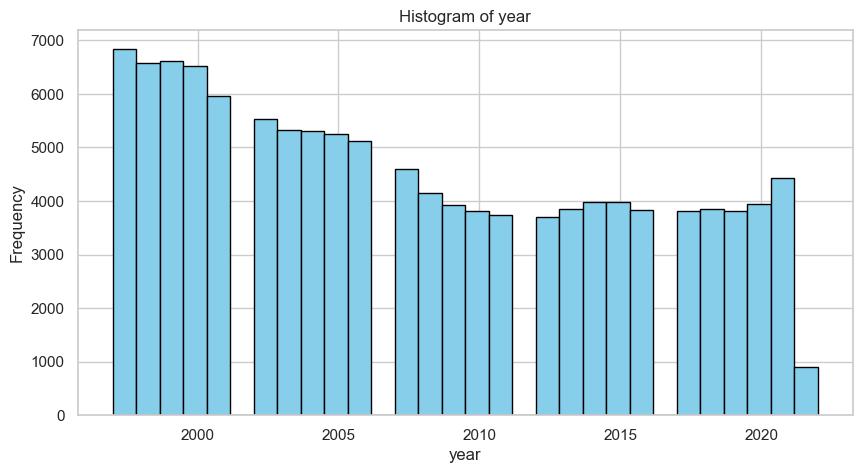

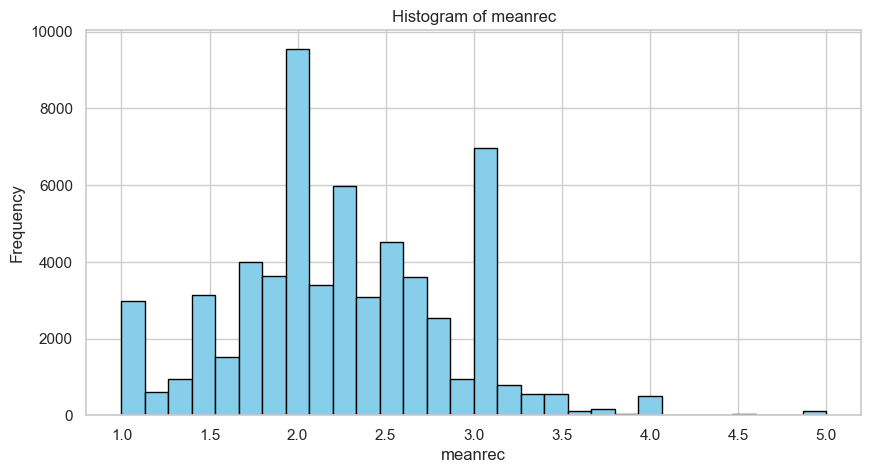

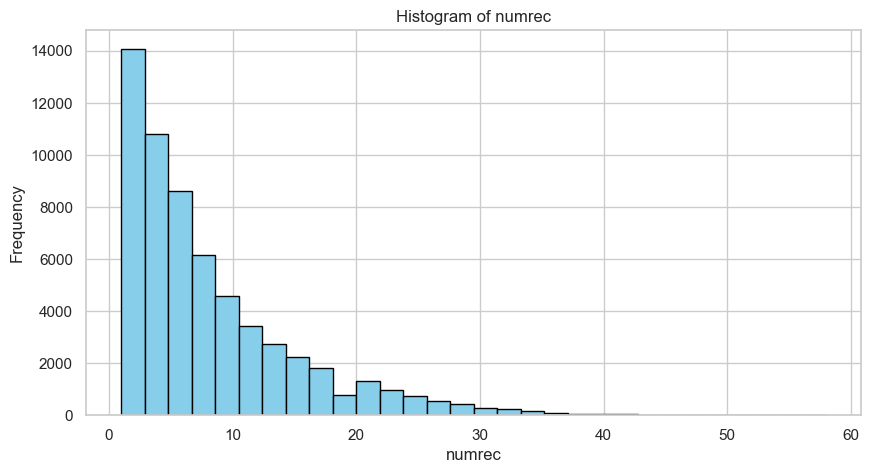

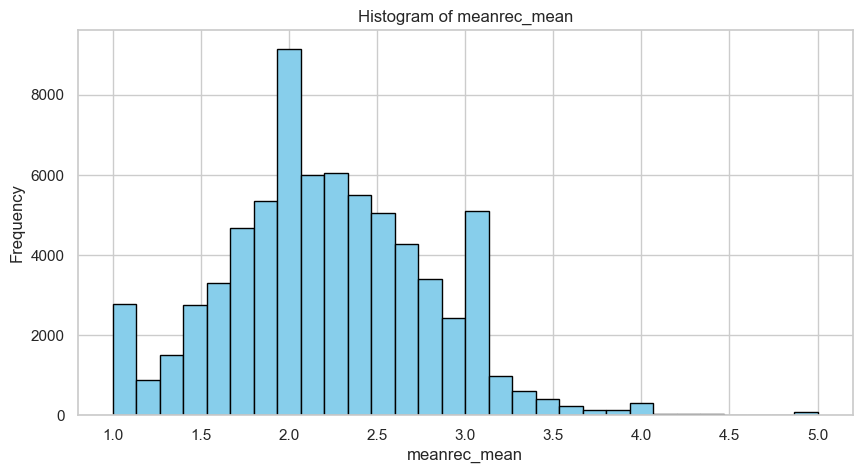

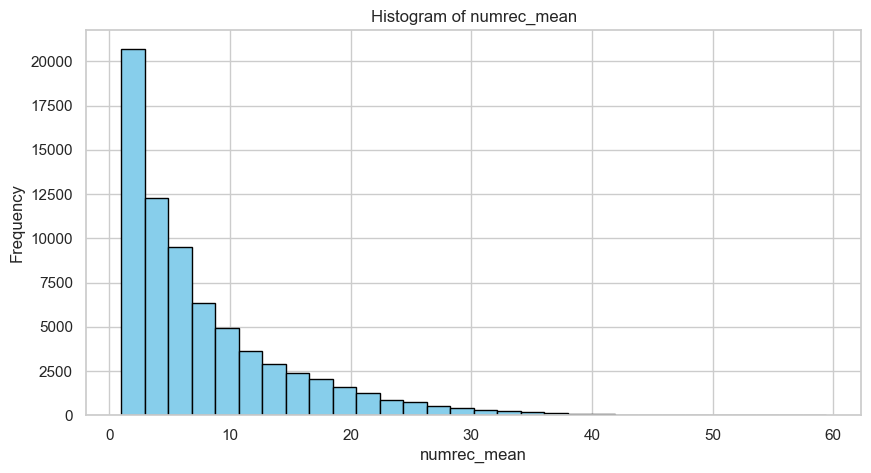

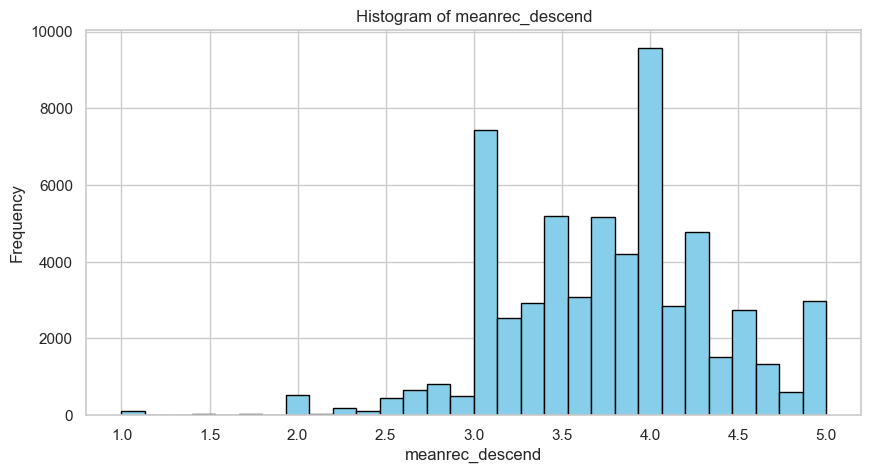

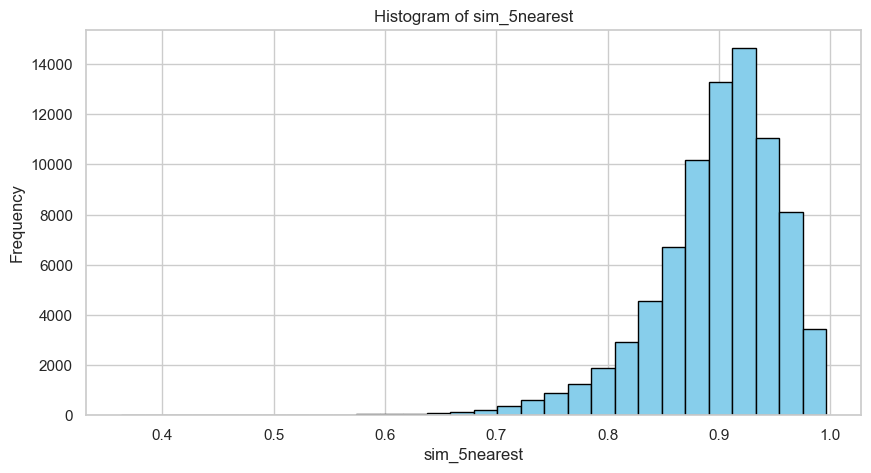

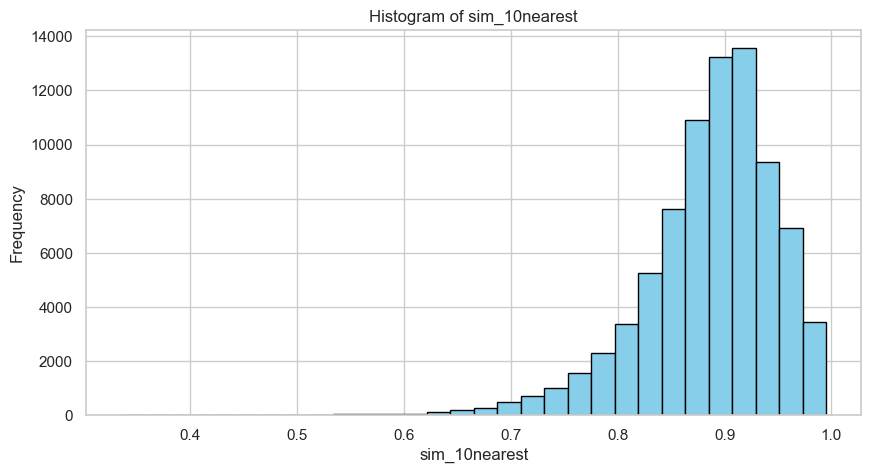

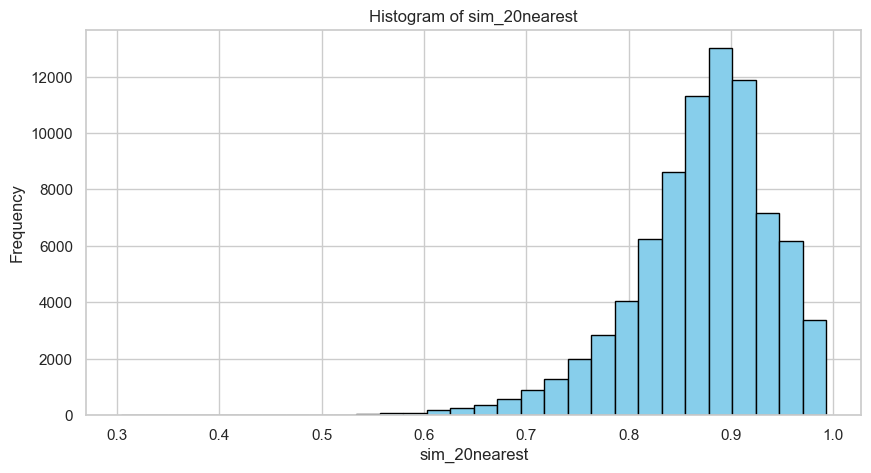

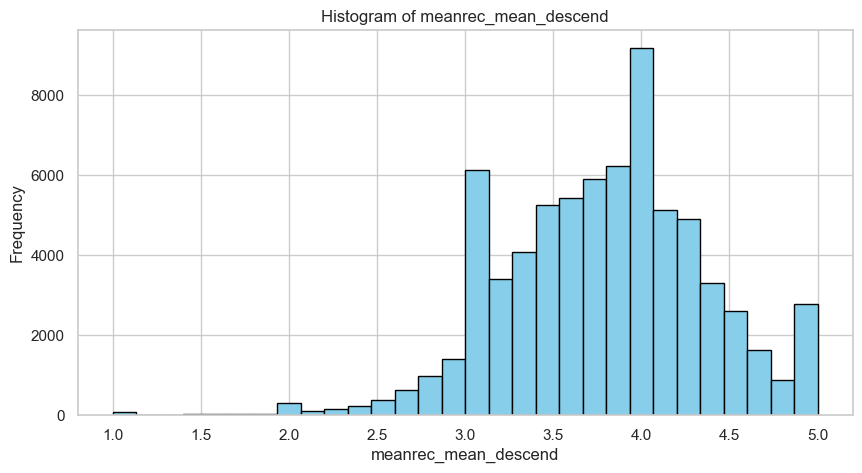

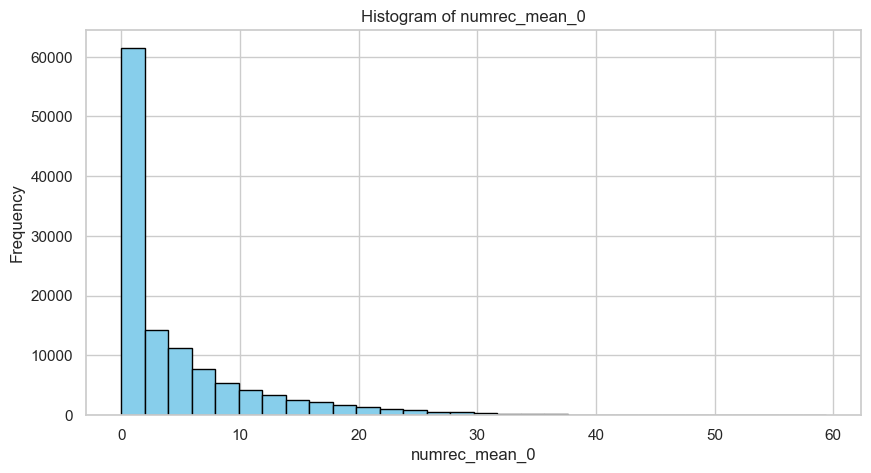

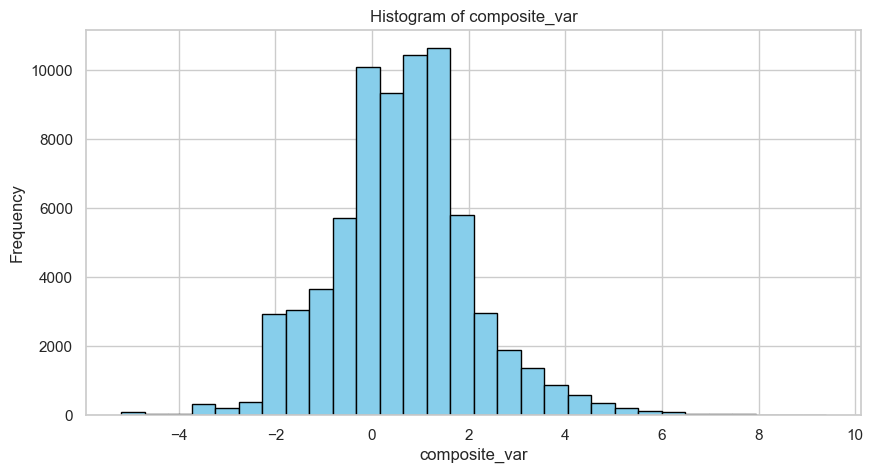

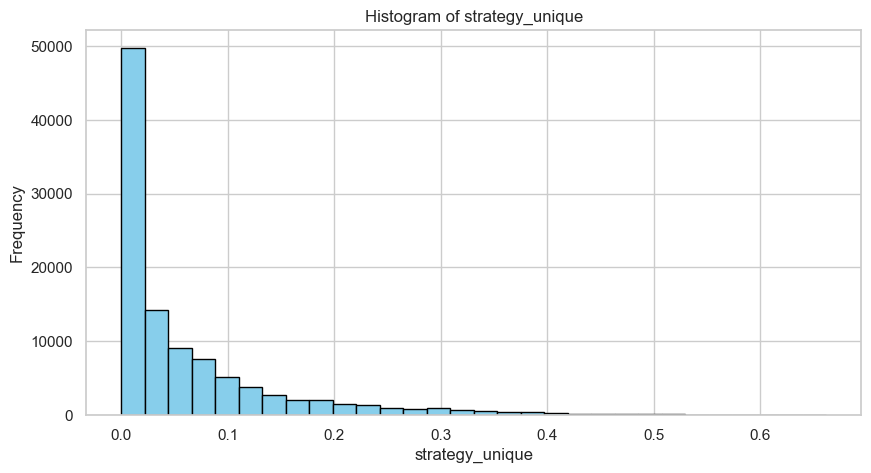

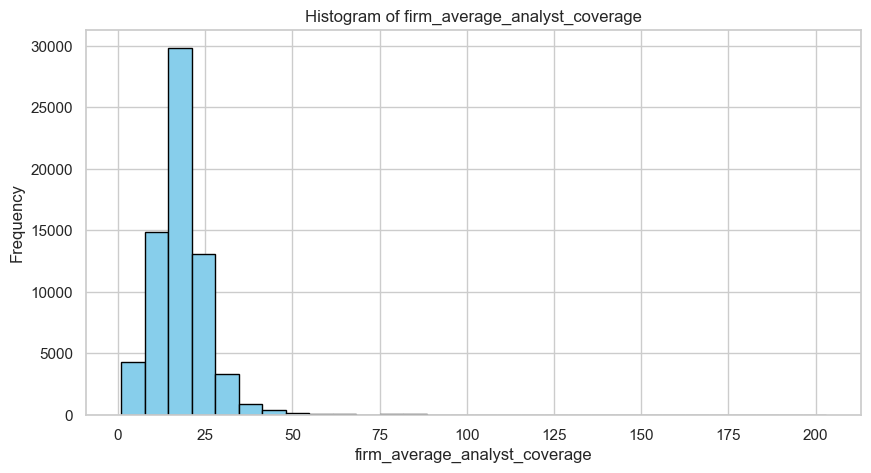

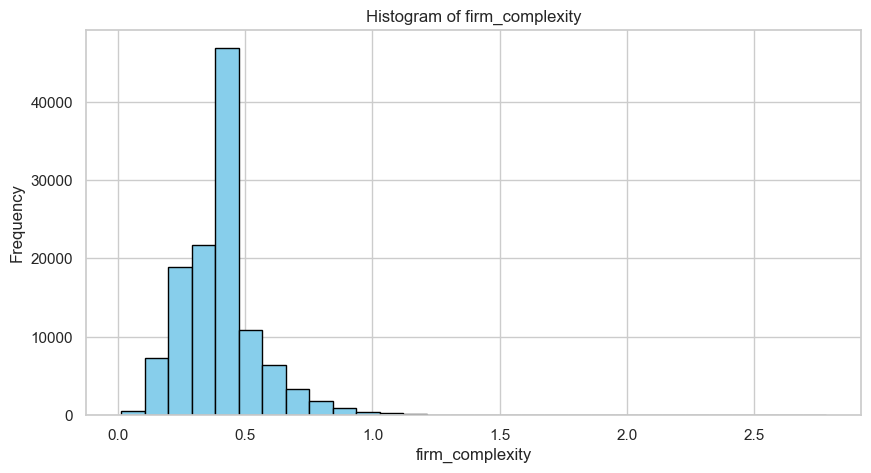

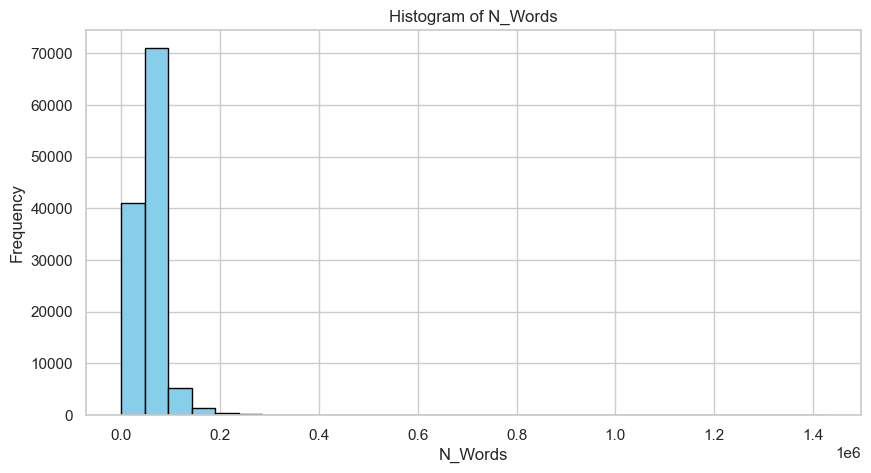

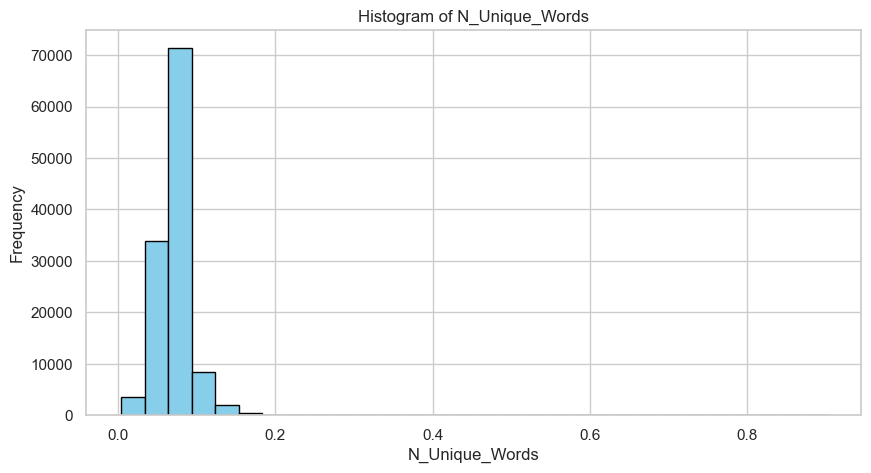

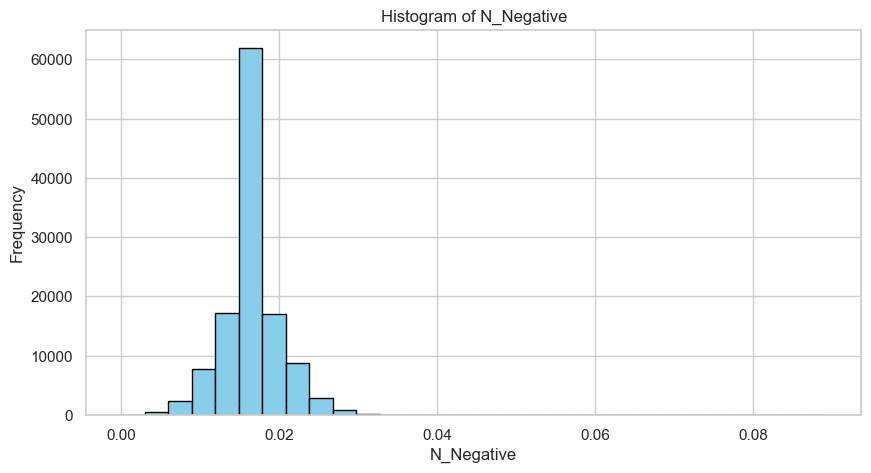

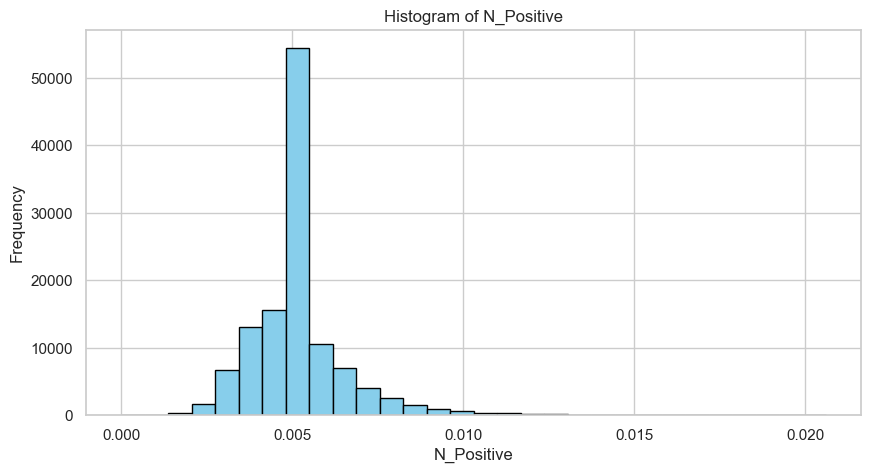

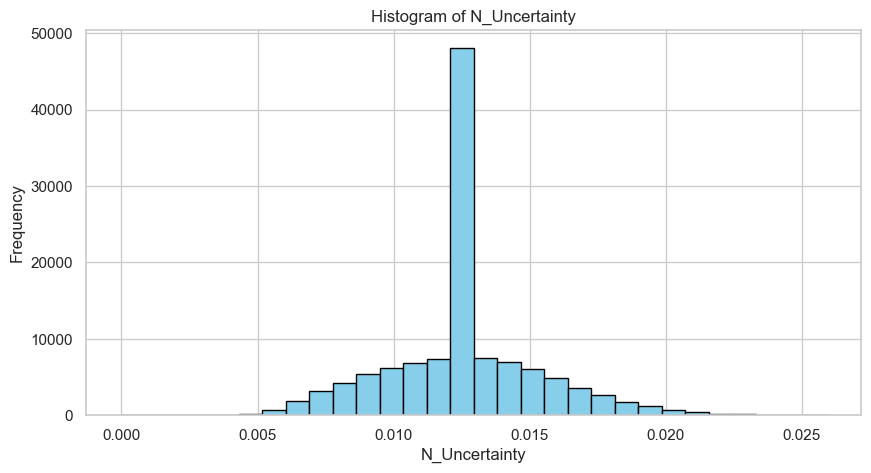

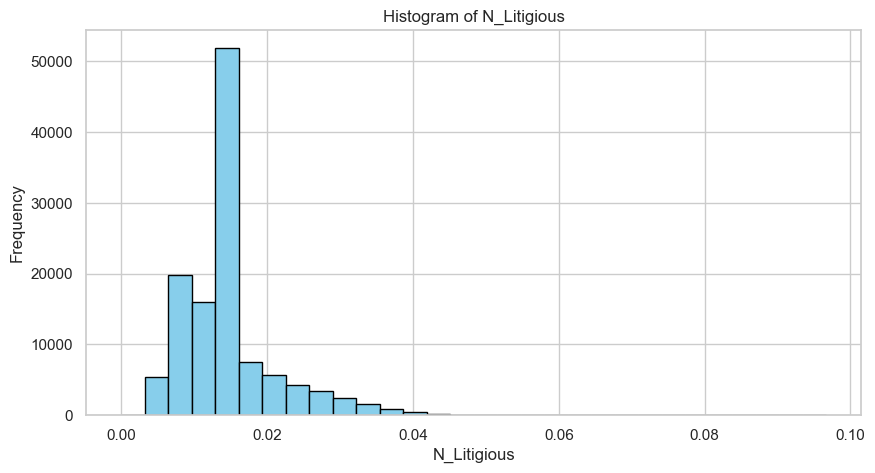

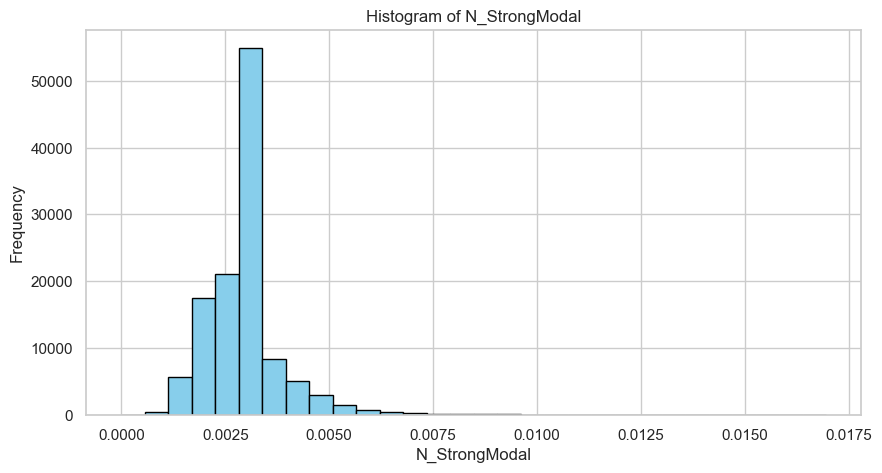

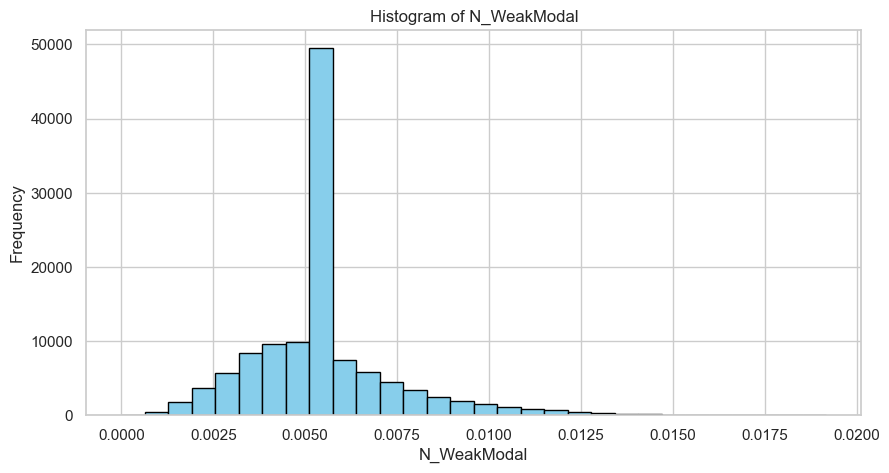

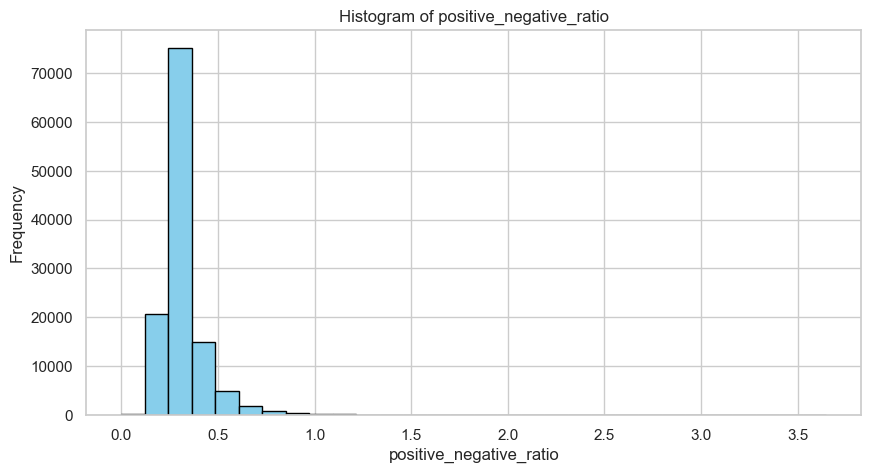

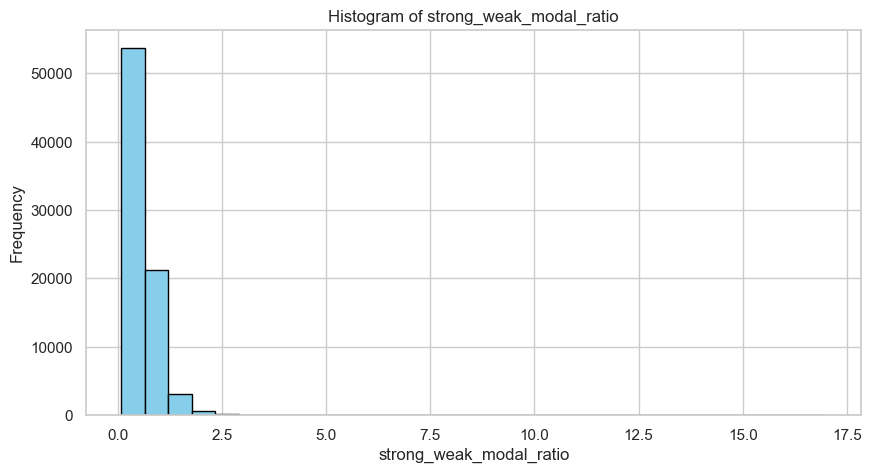

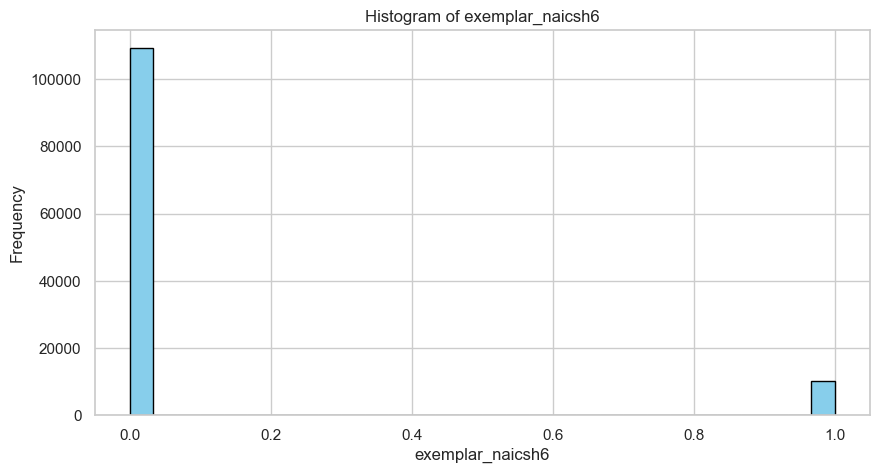

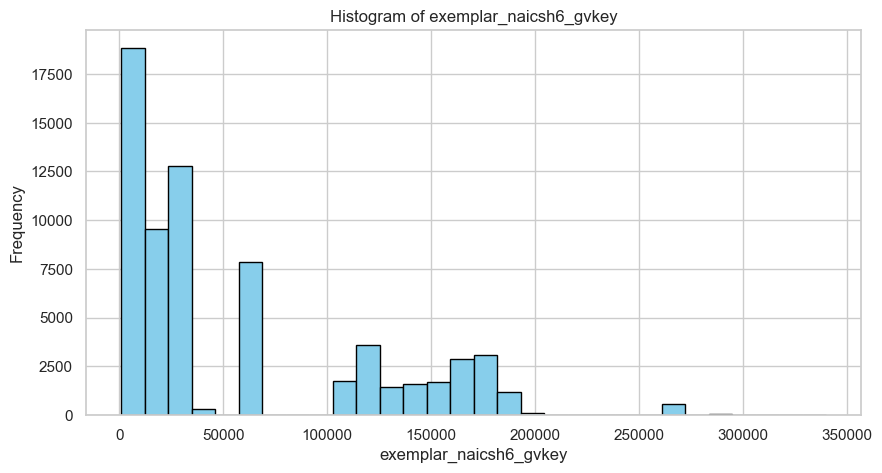

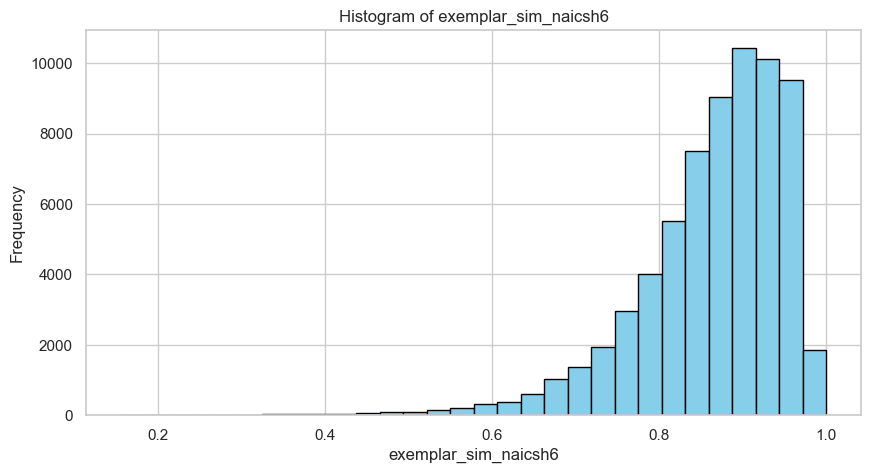

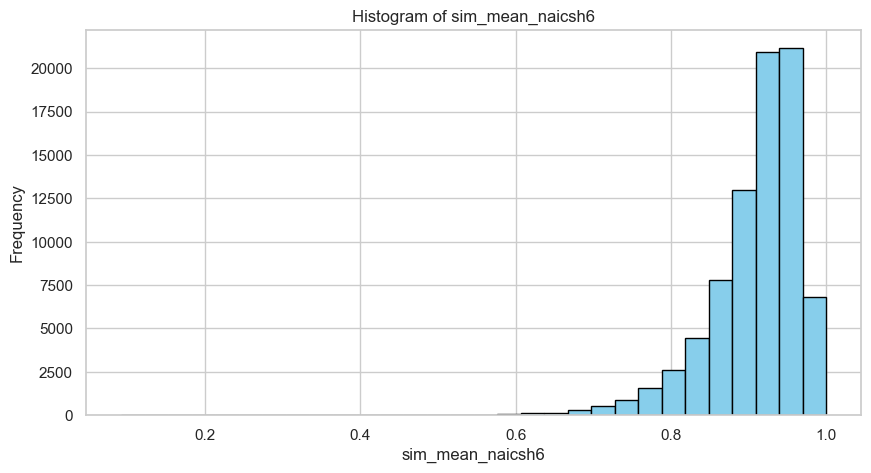

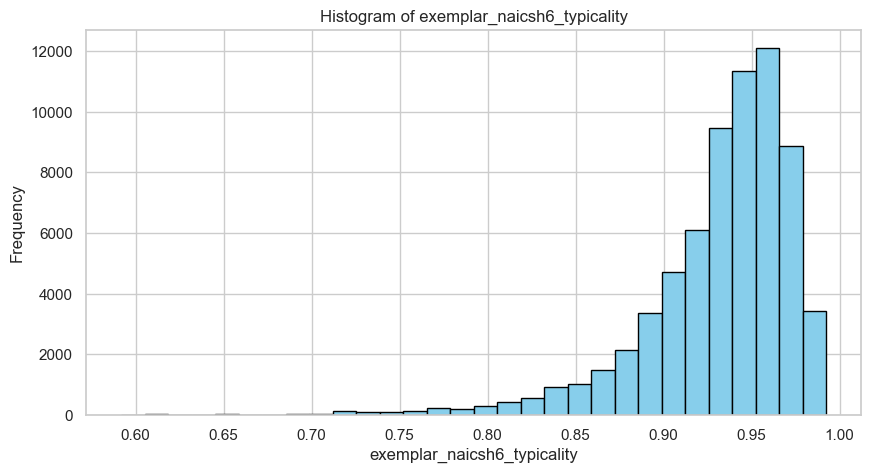

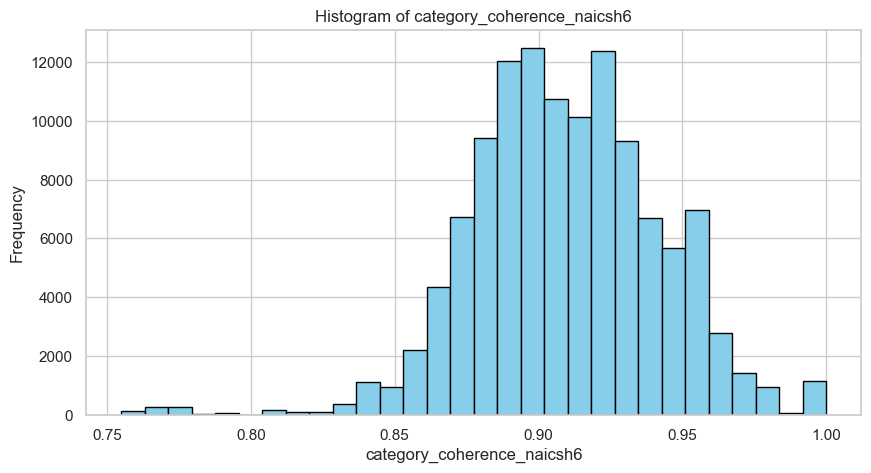

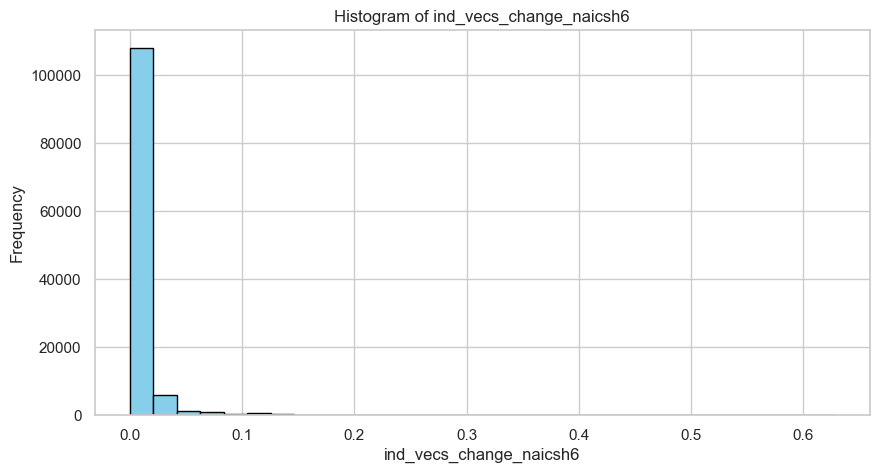

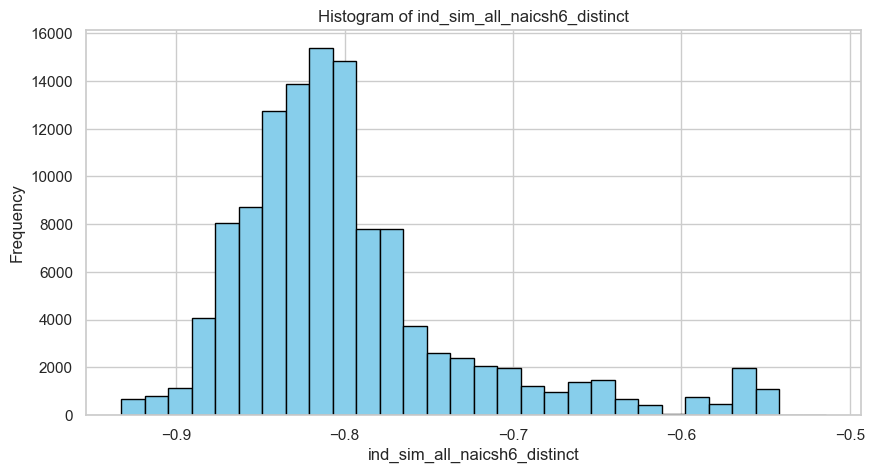

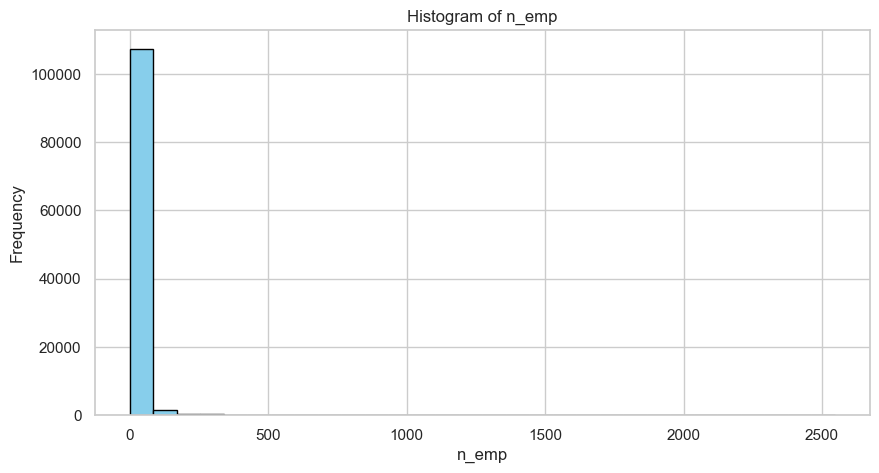

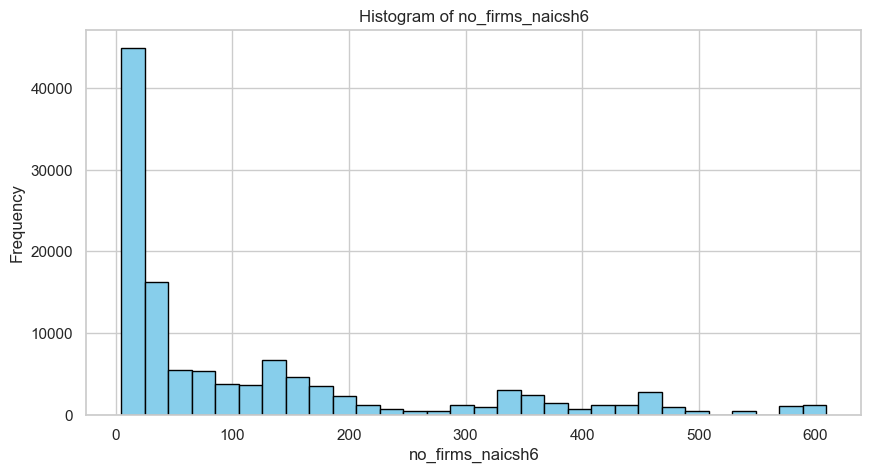

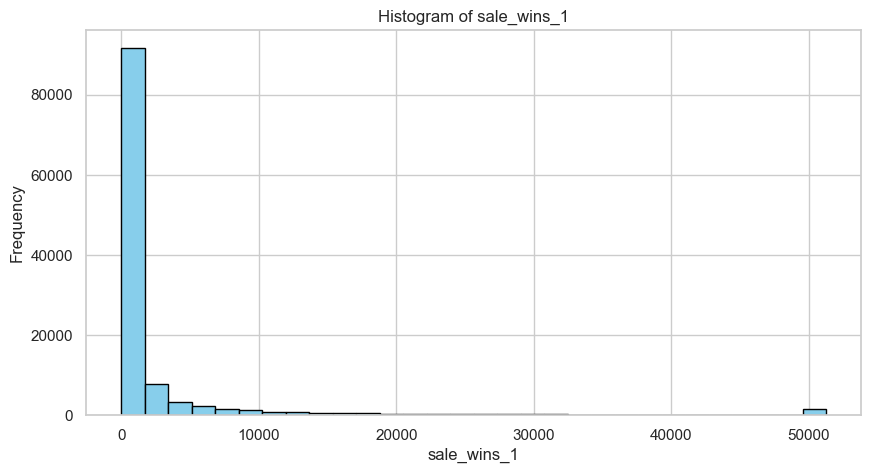

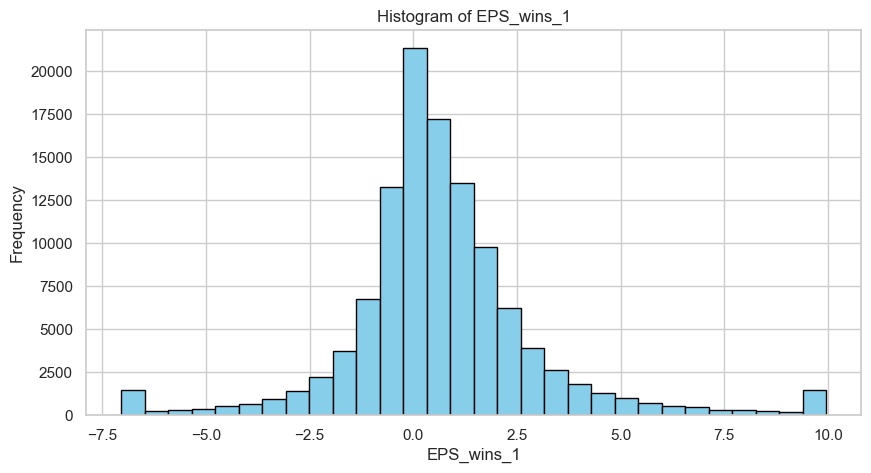

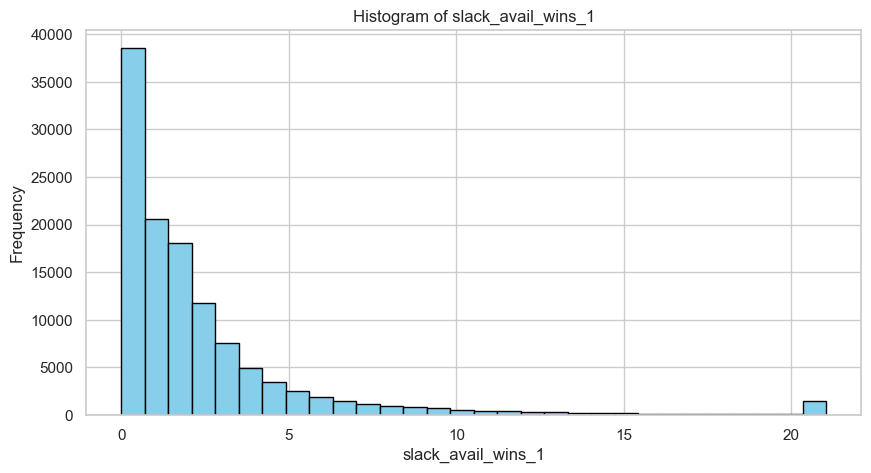

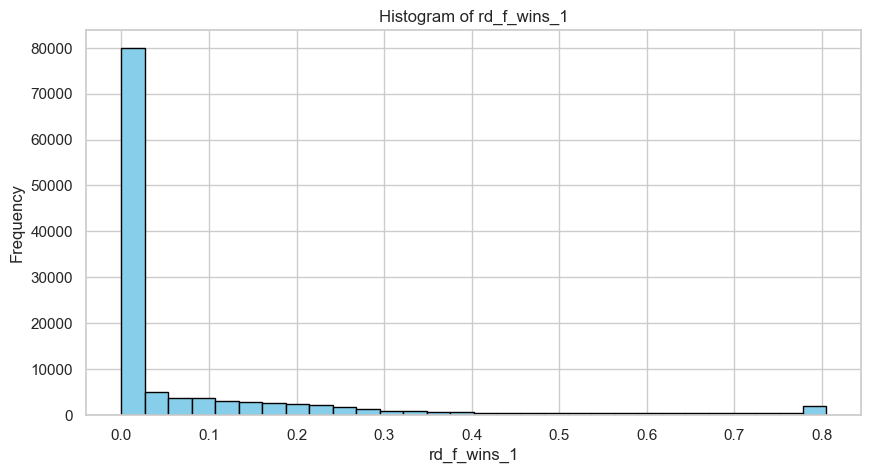

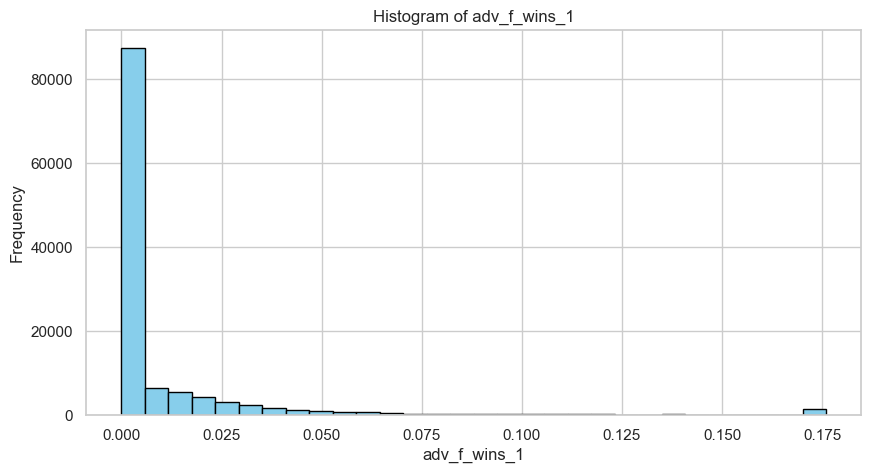

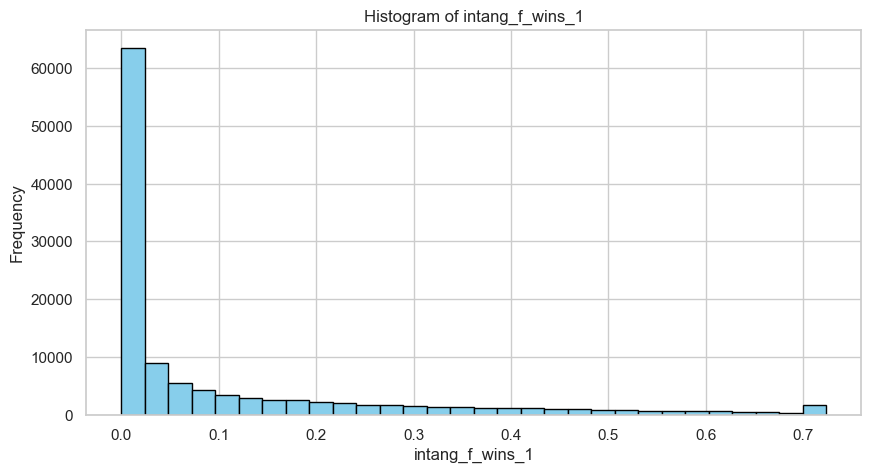

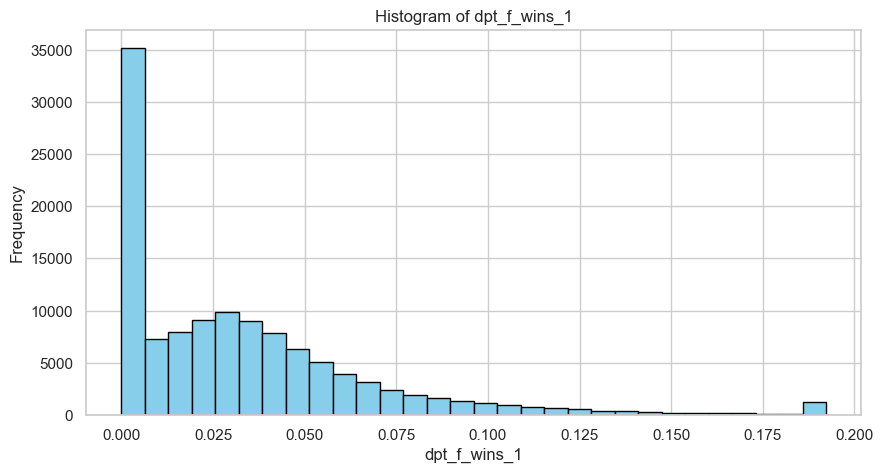

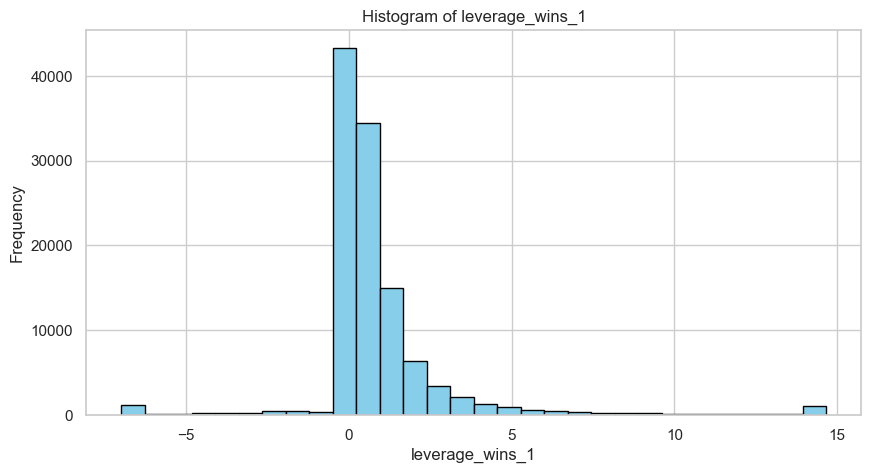

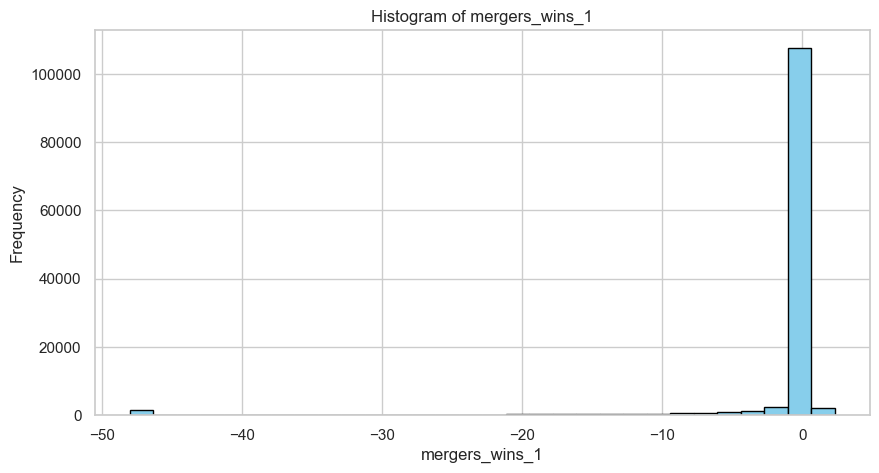

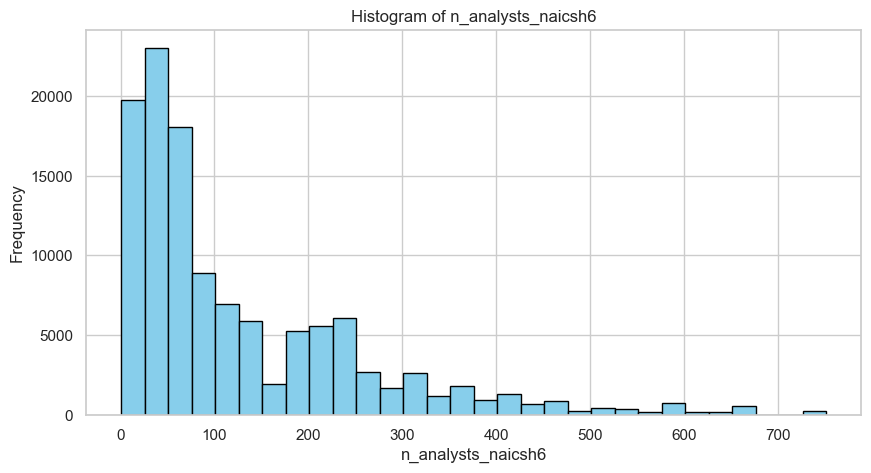

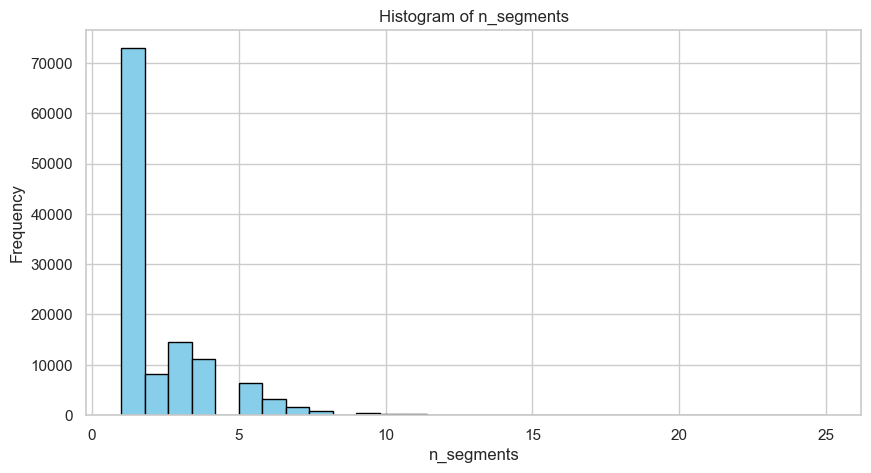

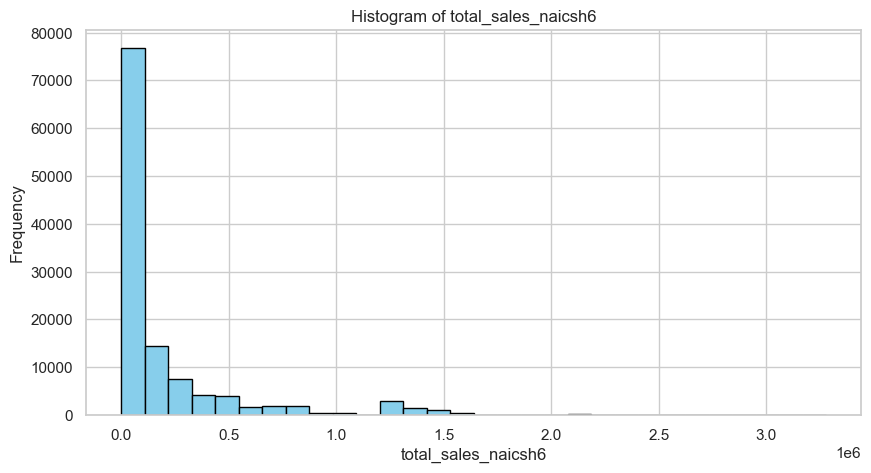

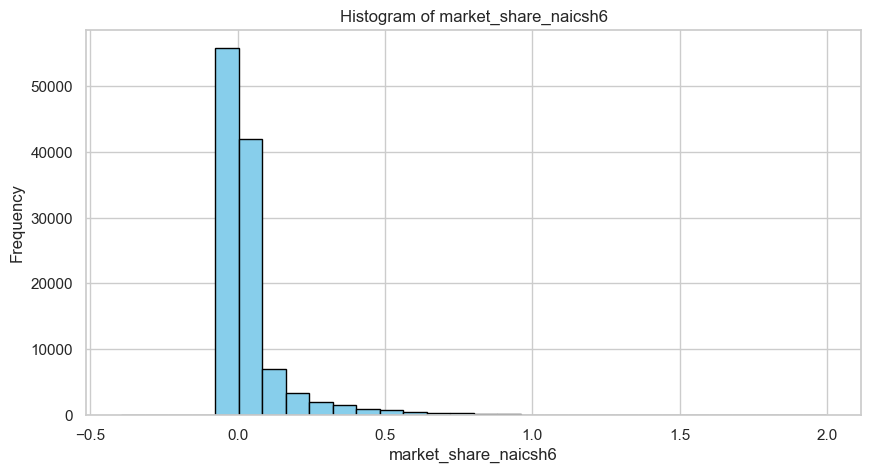

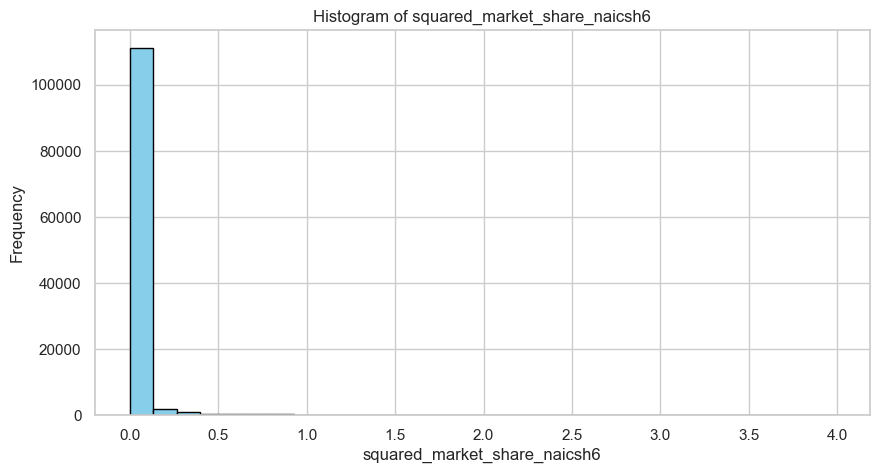

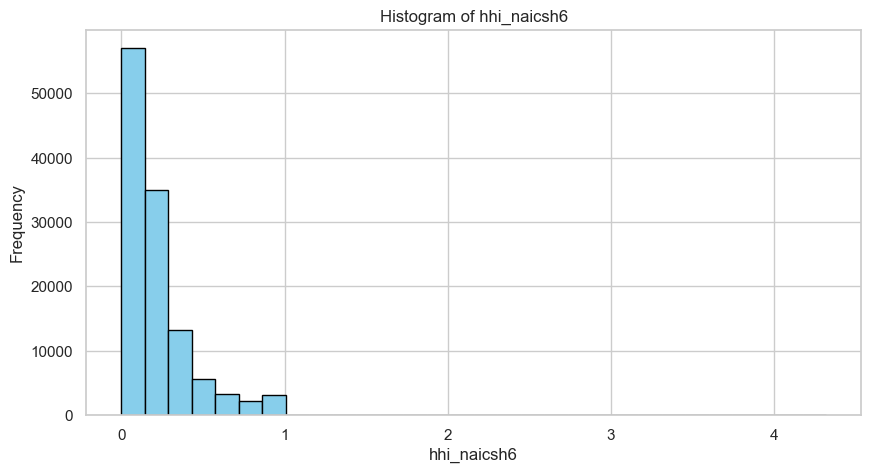

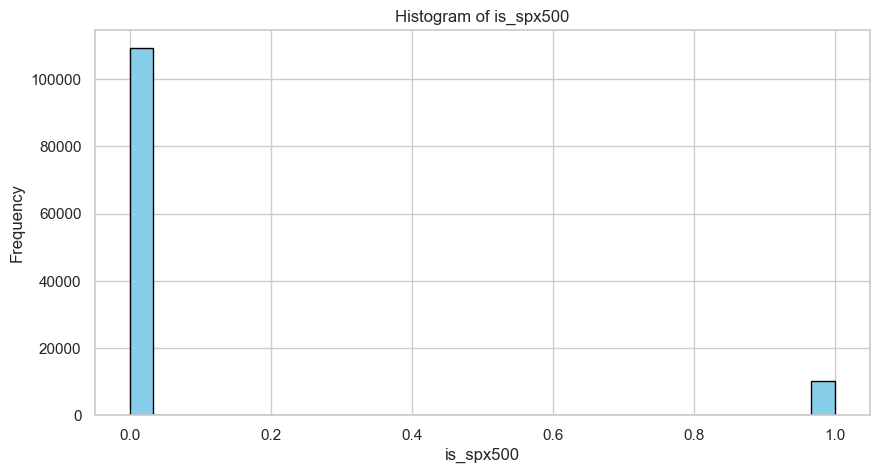

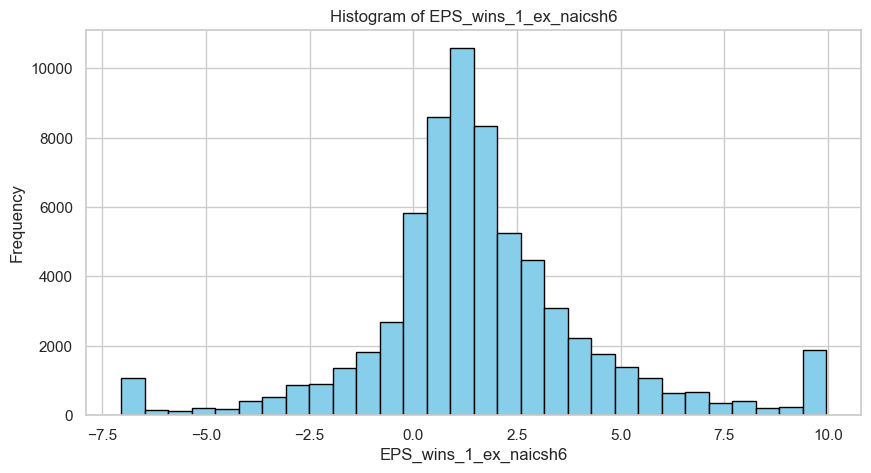

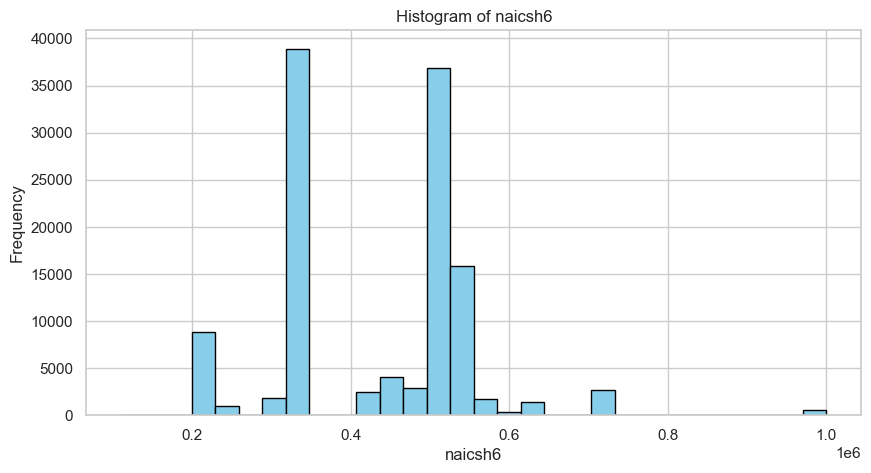

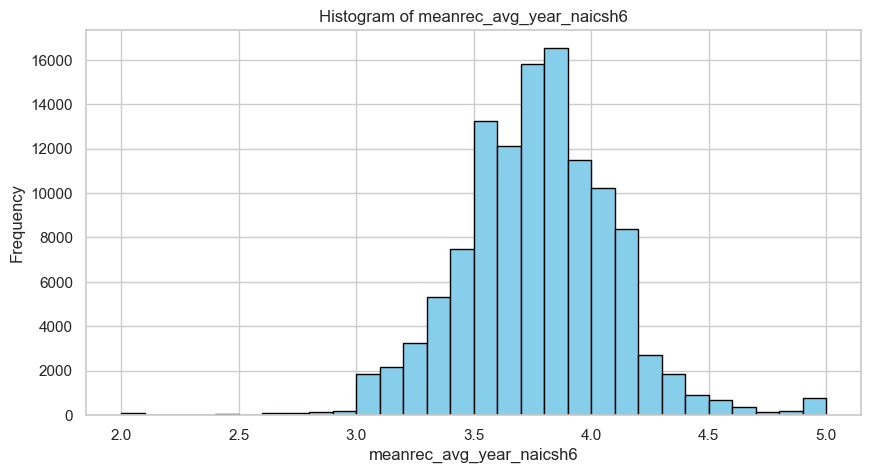

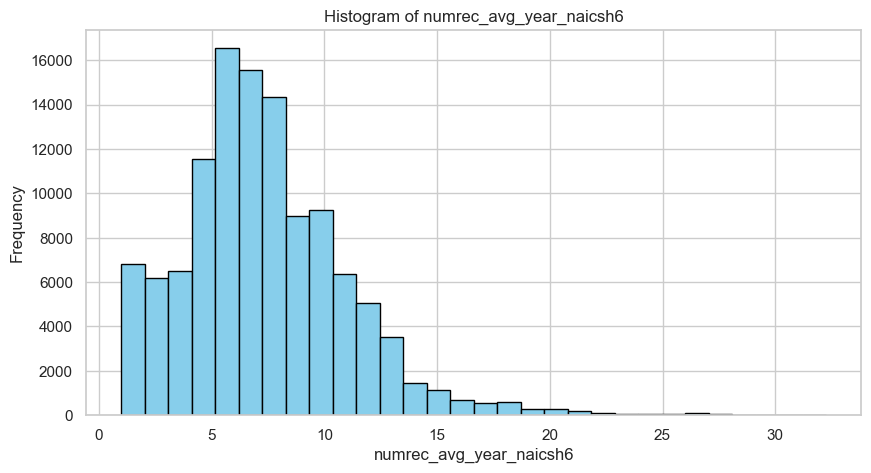

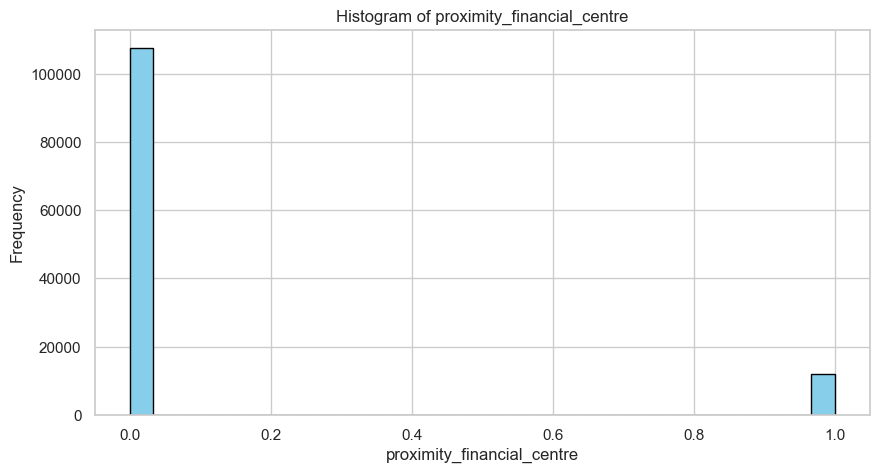

In [ ]:
compustat_select = compustat_select[compustat_select[f'no_firms_{ind_col}'] > 4]

for column in compustat_select.columns:
    # We don't want to plot for 'GVKEY'
    if column != 'GVKEY':
        plt.figure(figsize=(10,5))
        
        # If the column is boolean, convert True/False to 1/0
        if compustat_select[column].dtype == 'bool':
            data = compustat_select[column].map({True: 1, False: 0})
        else:
            data = compustat_select[column]
        
        plt.hist(data.dropna(), bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

## Visualizing select variables

In [ ]:
compustat[['GVKEY', 'year', 'meanrec_descend', 'numrec_mean_0']].to_csv('../data/meanrec_numrec_visualization.csv', index=False)

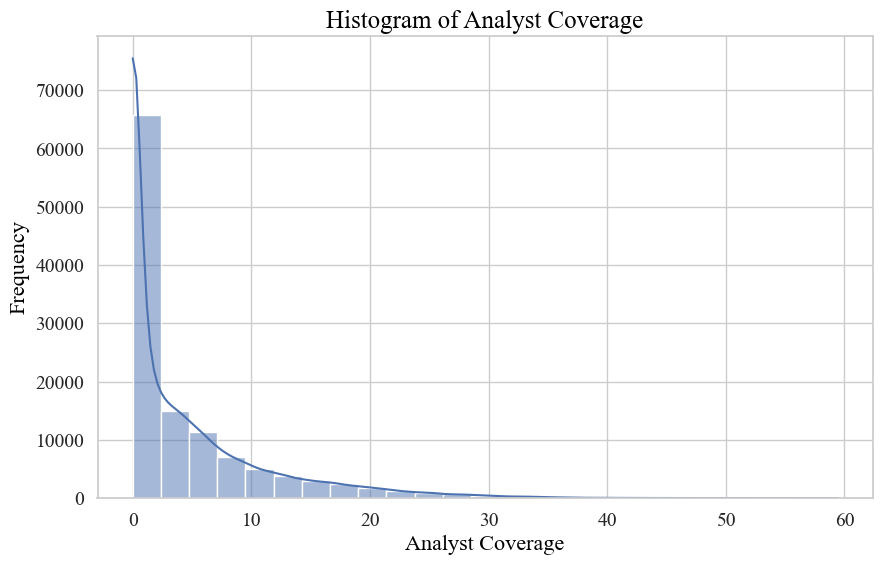

In [ ]:
# visualize the distribution of meanrec_mean_descend
# Creating a histogram with a smoother KDE line for 'meanrec_descend'
plt.figure(figsize=(10, 6))
sns.histplot(compustat_select['numrec_mean_0'],  kde=True, bins=25, kde_kws={"bw_adjust": 1})
plt.title('Histogram of Analyst Coverage', fontsize=18, color='black')
plt.xlabel('Analyst Coverage', fontsize=16, color='black')
plt.ylabel('Frequency', fontsize=16, color='black')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("../data/figures/analyst_coverage_distribution.png", dpi=900)
plt.show()

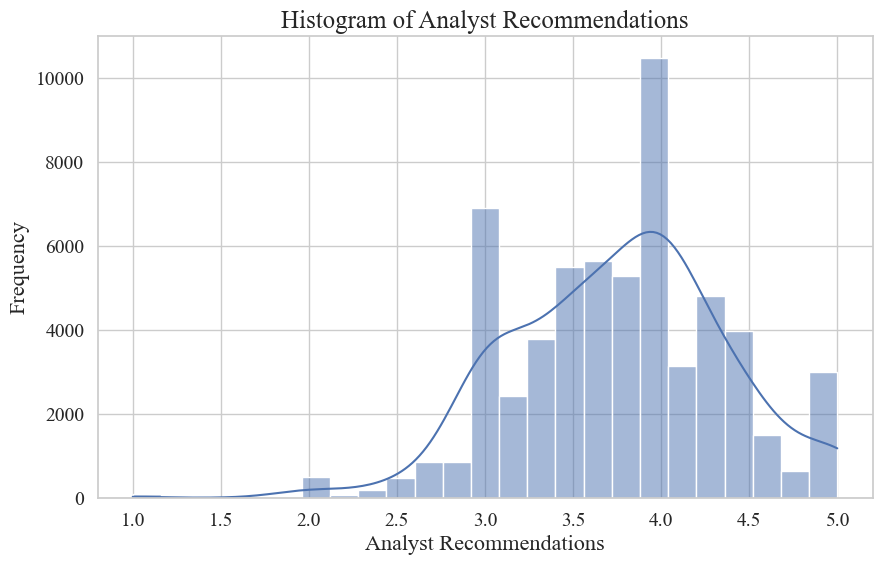

In [ ]:
# visualize the distribution of meanrec_mean_descend
# Creating a histogram with a smoother KDE line for 'meanrec_descend'
plt.figure(figsize=(10, 6))
sns.histplot(compustat_select['meanrec_descend'],  kde=True, bins=25, kde_kws={"bw_adjust": 3})
plt.title('Histogram of Analyst Recommendations', fontsize=18)
plt.xlabel('Analyst Recommendations', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("../data/figures/analyst_recommendations_distribution.png", dpi=900)
plt.show()

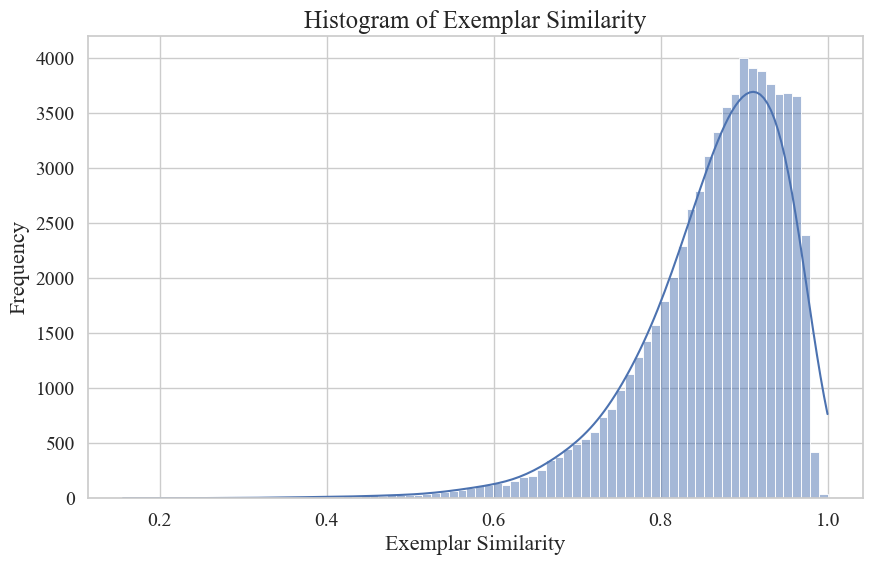

In [ ]:
# visualize the distribution of meanrec_mean_descend
# Creating a histogram with a smoother KDE line for 'meanrec_descend'
plt.figure(figsize=(10, 6))
sns.histplot(compustat_select[f'exemplar_sim_{ind_col}'],  kde=True, bins=80, kde_kws={"bw_adjust": 3})
plt.title('Histogram of Exemplar Similarity', fontsize=18)
plt.xlabel('Exemplar Similarity', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("../data/figures/exemplar_simiarlity_distribution.png", dpi=900)
plt.show()

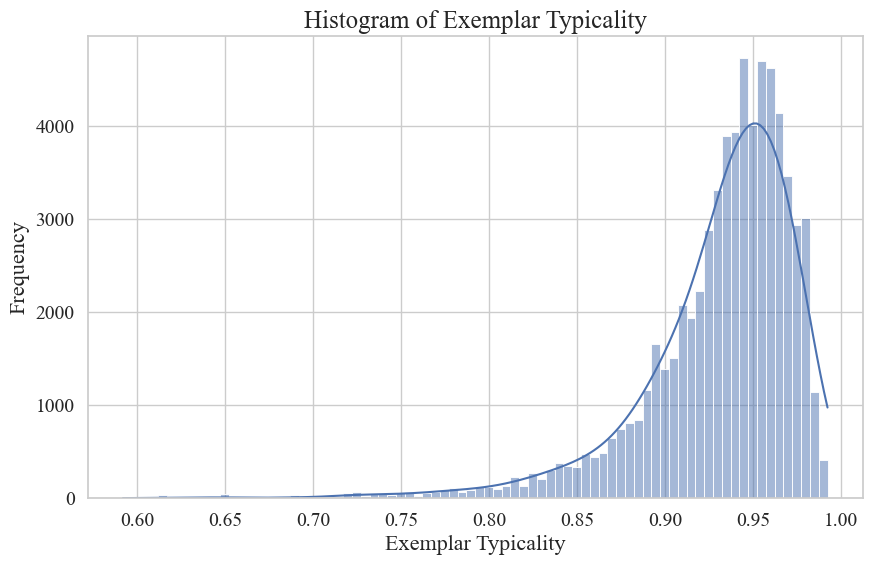

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(compustat_select[f'exemplar_{ind_col}_typicality'],  kde=True, bins=80, kde_kws={"bw_adjust": 3})
plt.title('Histogram of Exemplar Typicality', fontsize=18)
plt.xlabel('Exemplar Typicality', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("../data/figures/exemplar_typicality_distribution.png", dpi=900)
plt.show()

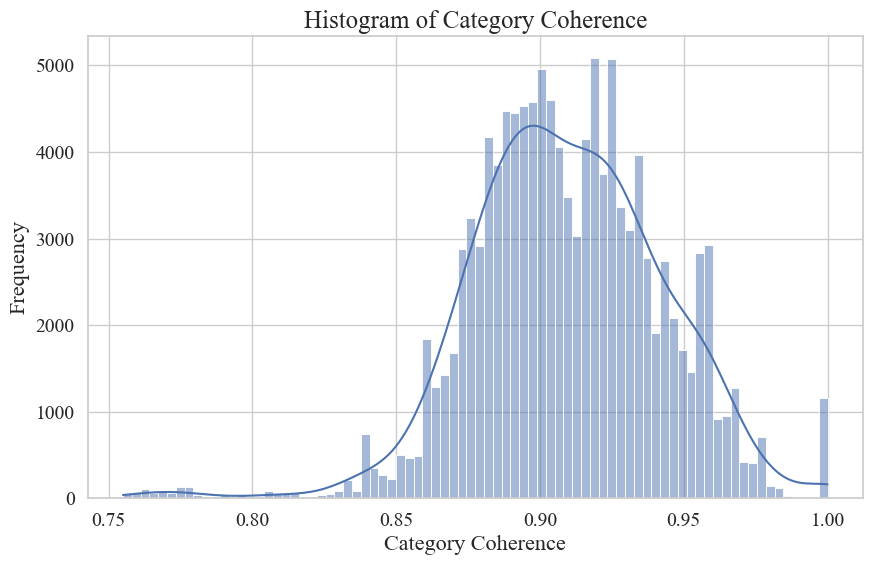

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(compustat_select[f'category_coherence_{ind_col}'],  kde=True, bins=80, kde_kws={"bw_adjust": 3})
plt.title('Histogram of Category Coherence', fontsize=18)
plt.xlabel('Category Coherence', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("../data/figures/category_coherence_distribution.png", dpi=900)
plt.show()

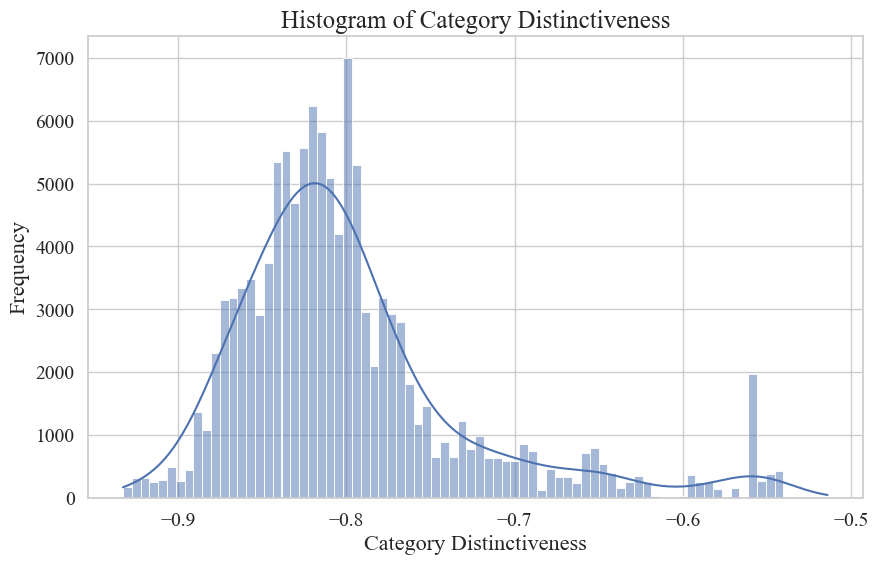

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(compustat_select[f'ind_sim_all_{ind_col}_distinct'],  kde=True, bins=80, kde_kws={"bw_adjust": 3})
plt.title('Histogram of Category Distinctiveness', fontsize=18)
plt.xlabel('Category Distinctiveness', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("../data/figures/category_distinctiveness_distribution.png", dpi=900)
plt.show()